In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.gaussian_process as gp
from scipy.integrate import solve_ivp
import scipy.linalg as la
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
import gp_regression as gpr

In [3]:
%matplotlib notebook
plt.style.use('seaborn')

## Forward Model

In [152]:
def lotka_volterra(t,y,a,b,c,d):
    dy = np.empty_like(y)
    dy[0] = a*y[0]-b*y[0]*y[1]
    dy[1] = d*y[0]*y[1]-c*y[1]
    return dy

In [153]:
def solve_lv(T,y0,a,b,c,d):
    sol = solve_ivp(lotka_volterra,(T[0],T[-1]),y0,t_eval=T,args=(a,b,c,d))
    return sol.y

## Metropolis-Hastings

In [154]:
def rw_metropolis_hastings(f,llh,lpr,cov,x0,n,burn_in,update=50,verbose=False):
    X = [x0]
    y = f(x0)
    loglikelihood = [llh(y)]
    logprior = [lpr(x0)]
    accepted = 0
    while len(X) < n+burn_in:
        # update proposal covariance
        if update:
            if len(X) < burn_in and not len(X)%update:
                cov = np.cov(X,rowvar=False)
            
        # propose new parameters
        u = X[-1] + stats.multivariate_normal.rvs(cov=cov)

        # evaluate prior
        lpr_u = lpr(u)
        if lpr_u > np.NINF:
            # evaluate forward model
            y_u = f(u)

            # evaluate likelihood and prior
            llh_u = llh(y_u)

            logalpha = llh_u + lpr_u - loglikelihood[-1] - logprior[-1]
        else:
            logalpha = np.NINF
        
        # metropolis-hastings accept/reject
        if np.log(np.random.rand()) < logalpha:
            X.append(u)
            y = y_u
            loglikelihood.append(llh_u)
            logprior.append(lpr_u)
            if len(X) > burn_in: accepted += 1
        else:
            X.append(X[-1])
            loglikelihood.append(loglikelihood[-1])
            logprior.append(logprior[-1])
        if verbose and not len(X)%100:
            print(len(X))
    
    print("acceptance rate:",accepted/n)
    return np.array(X[burn_in:])

## Standard case (no surrogate data)

In [155]:
# choose true parameters
y0 = [2,.5]
a = 1
b = 1
c = 1
d = 1

# generate simulated data
T = np.linspace(0,10,10)
y = solve_lv(T,y0,a,b,c,d)

# add noise
sigma = 0.02
y_noisy = np.abs(y + sigma*np.random.randn(y.shape[0],y.shape[1]))

In [156]:
# define likelihood and prior
# gaussian likelihood
def llh_std(y):
    return -((y-y_noisy)**2).sum()

# uniform prior
def lpr_std(x):
    if np.all((0<x)&(x<10)):
        return 0
    else:
        return np.NINF

In [157]:
# define forward model
def f_std(x):
    return solve_lv(T,x[:2],1,x[2],x[3],1)

In [158]:
# sample
x0 = np.array([y_noisy[0,0],y_noisy[1,0],1,1])
cov = .03*np.eye(4)
X_std = rw_metropolis_hastings(f_std,llh_std,lpr_std,cov,x0,n=100000,burn_in=3000,update=False,verbose=False)

acceptance rate: 0.2357


In [159]:
kdes_std = []
for col in X_std.T:
    kdes_std.append(gaussian_kde(col))

<IPython.core.display.Javascript object>


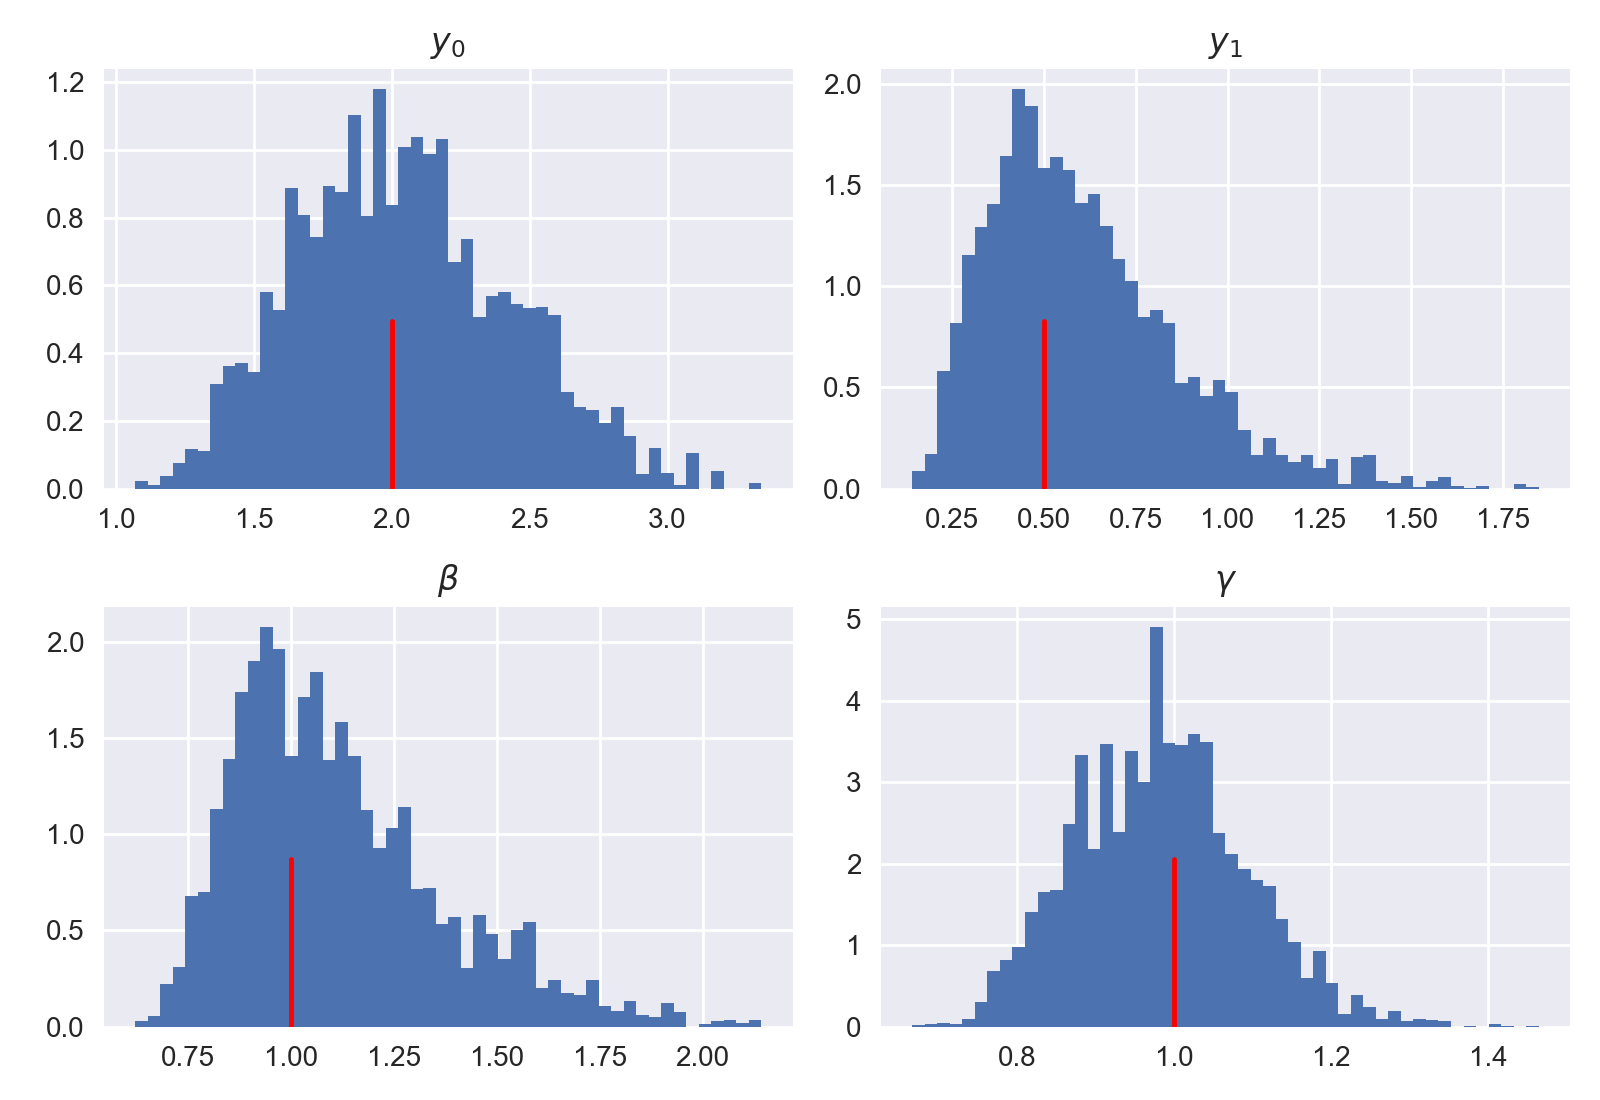

In [160]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(X_std[:,0],bins=50,density=True)
plt.axvline(y0[0],ymax=.4,c='r')
plt.title('$y_0$')

plt.subplot(2,2,2)
plt.hist(X_std[:,1],bins=50,density=True)
plt.axvline(y0[1],ymax=.4,c='r')
plt.title('$y_1$')

plt.subplot(2,2,3)
plt.hist(X_std[:,2],bins=50,density=True)
plt.axvline(b,ymax=.4,c='r')
plt.title('$\\beta$')

plt.subplot(2,2,4)
plt.hist(X_std[:,3],bins=50,density=True)
plt.axvline(c,ymax=.4,c='r')
plt.title('$\\gamma$')

plt.tight_layout()
plt.show()

## Surrogate data case

In [161]:
# fit GPs to noisy data
# kernel1 = 0.5*gp.kernels.RBF(length_scale=3**0.5)+0.1**0.5*gp.kernels.WhiteKernel()
# kernel2 = 0.5*gp.kernels.RBF(length_scale=3**0.5)+0.1**0.5*gp.kernels.WhiteKernel()
kernel1 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel()
kernel2 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel()
y1_gp = gp.GaussianProcessRegressor(kernel1)
y2_gp = gp.GaussianProcessRegressor(kernel2)
y1_gp = y1_gp.fit(T[:,np.newaxis],y_noisy[0])
y2_gp = y2_gp.fit(T[:,np.newaxis],y_noisy[1])

/Users/hringer/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [162]:
# define high-res time points for evaluation
T_sur = np.linspace(0,10,201)

# compute mean and covariance of GPs
mean1,cov1 = y1_gp.predict(T_sur[:,np.newaxis],return_cov=True)
mean2,cov2 = y2_gp.predict(T_sur[:,np.newaxis],return_cov=True)

# compute eigendecompositions
e1,v1 = la.eig(cov1)
e2,v2 = la.eig(cov2)

# build weight matrices
W1 = np.sqrt(1/e1)@(v1.T)
W2 = np.sqrt(1/e2)@(v2.T)

In [163]:
# high res simulation
y_hr = solve_lv(T_sur,y0,a,b,c,d)

<IPython.core.display.Javascript object>


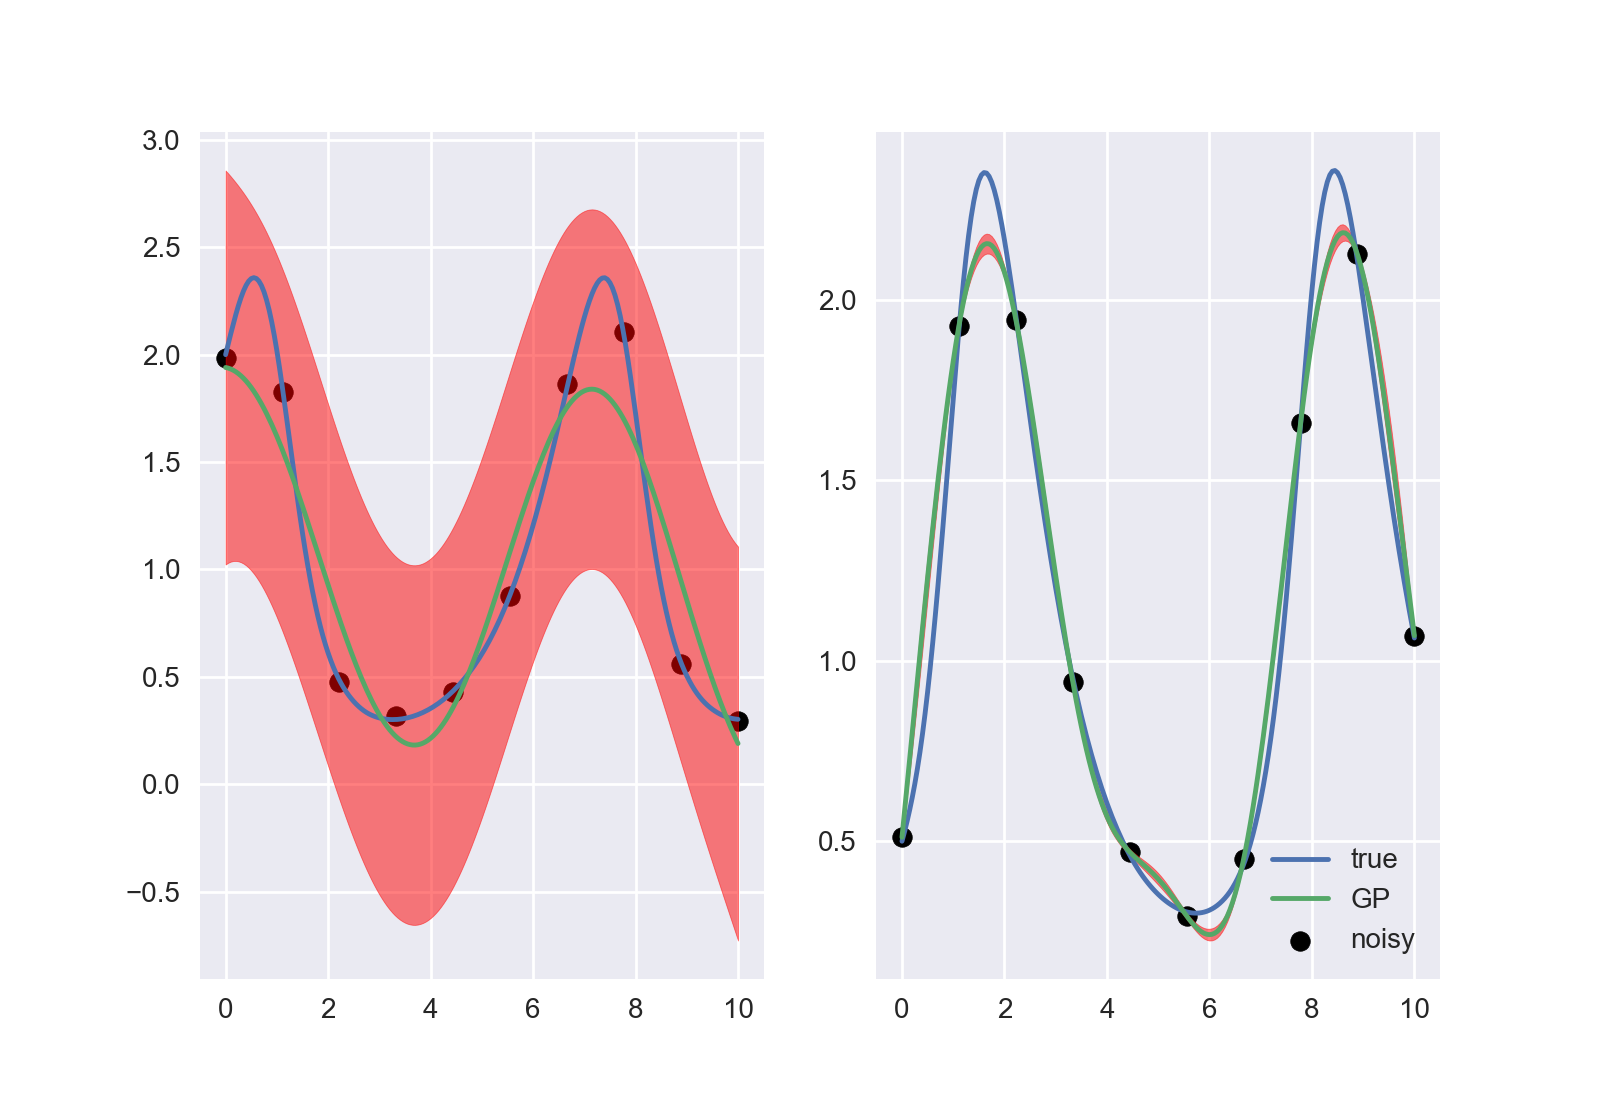

In [164]:
fig = plt.figure()
plt.subplot(121)
plt.plot(T_sur,y_hr[0],label='true')
plt.scatter(T,y_noisy[0],c='k',label='noisy')
plt.plot(T_sur,mean1,label='GP')
plt.fill_between(T_sur,mean1-2*np.sqrt(np.diag(cov1)),mean1+2*np.sqrt(np.diag(cov1)),color='r',alpha=.5)
plt.subplot(122)
plt.plot(T_sur,y_hr[1],label='true')
plt.scatter(T,y_noisy[1],c='k',label='noisy')
plt.plot(T_sur,mean2,label='GP')
plt.fill_between(T_sur,mean2-2*np.sqrt(np.diag(cov2)),mean2+2*np.sqrt(np.diag(cov2)),color='r',alpha=.5)
plt.legend()
plt.show()

In [165]:
# define likelihood and prior
# gaussian likelihood
def llh_sur(y):
    return -la.norm(W1@(y[0]-mean1))**2 - la.norm(W2@(y[1]-mean2))**2

# uniform prior
def lpr_sur(x):
    if np.all((0<x)&(x<10)):
        return 0
    else:
        return np.NINF

In [166]:
# define forward model
def f_sur(x):
    return solve_lv(T_sur,x[:2],1,x[2],x[3],1)

In [170]:
# sample
x0 = np.array([y_noisy[0,0],y_noisy[1,0],1,1])
cov = 0.000001*np.eye(4)
X_sur = rw_metropolis_hastings(f_sur,llh_sur,lpr_sur,cov,x0,n=10000,burn_in=1000,update=False,verbose=False)

acceptance rate: 0.1746


In [171]:
kdes_sur = []
for col in X_sur.T:
    kdes_sur.append(gaussian_kde(col))

<IPython.core.display.Javascript object>


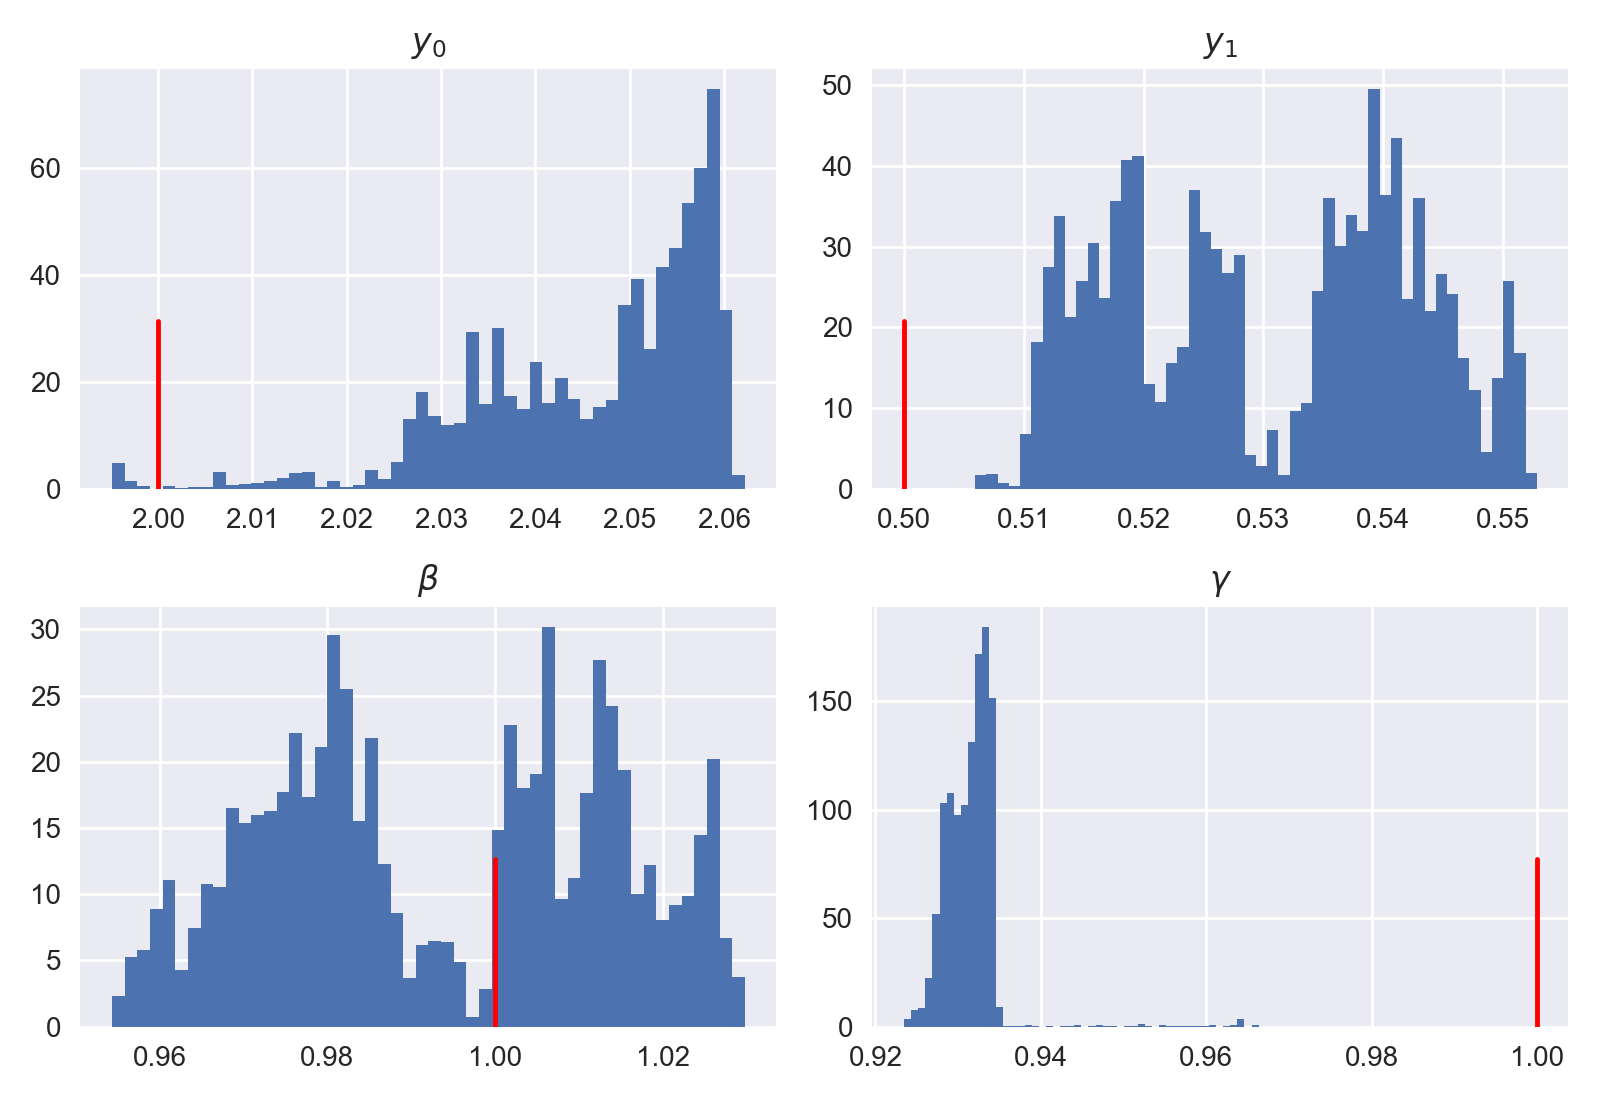

In [172]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(X_sur[:,0],bins=50,density=True)
plt.axvline(y0[0],ymax=.4,c='r')
plt.title('$y_0$')

plt.subplot(2,2,2)
plt.hist(X_sur[:,1],bins=50,density=True)
plt.axvline(y0[1],ymax=.4,c='r')
plt.title('$y_1$')

plt.subplot(2,2,3)
plt.hist(X_sur[:,2],bins=50,density=True)
plt.axvline(b,ymax=.4,c='r')
plt.title('$\\beta$')

plt.subplot(2,2,4)
plt.hist(X_sur[:,3],bins=50,density=True)
plt.axvline(c,ymax=.4,c='r')
plt.title('$\\gamma$')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


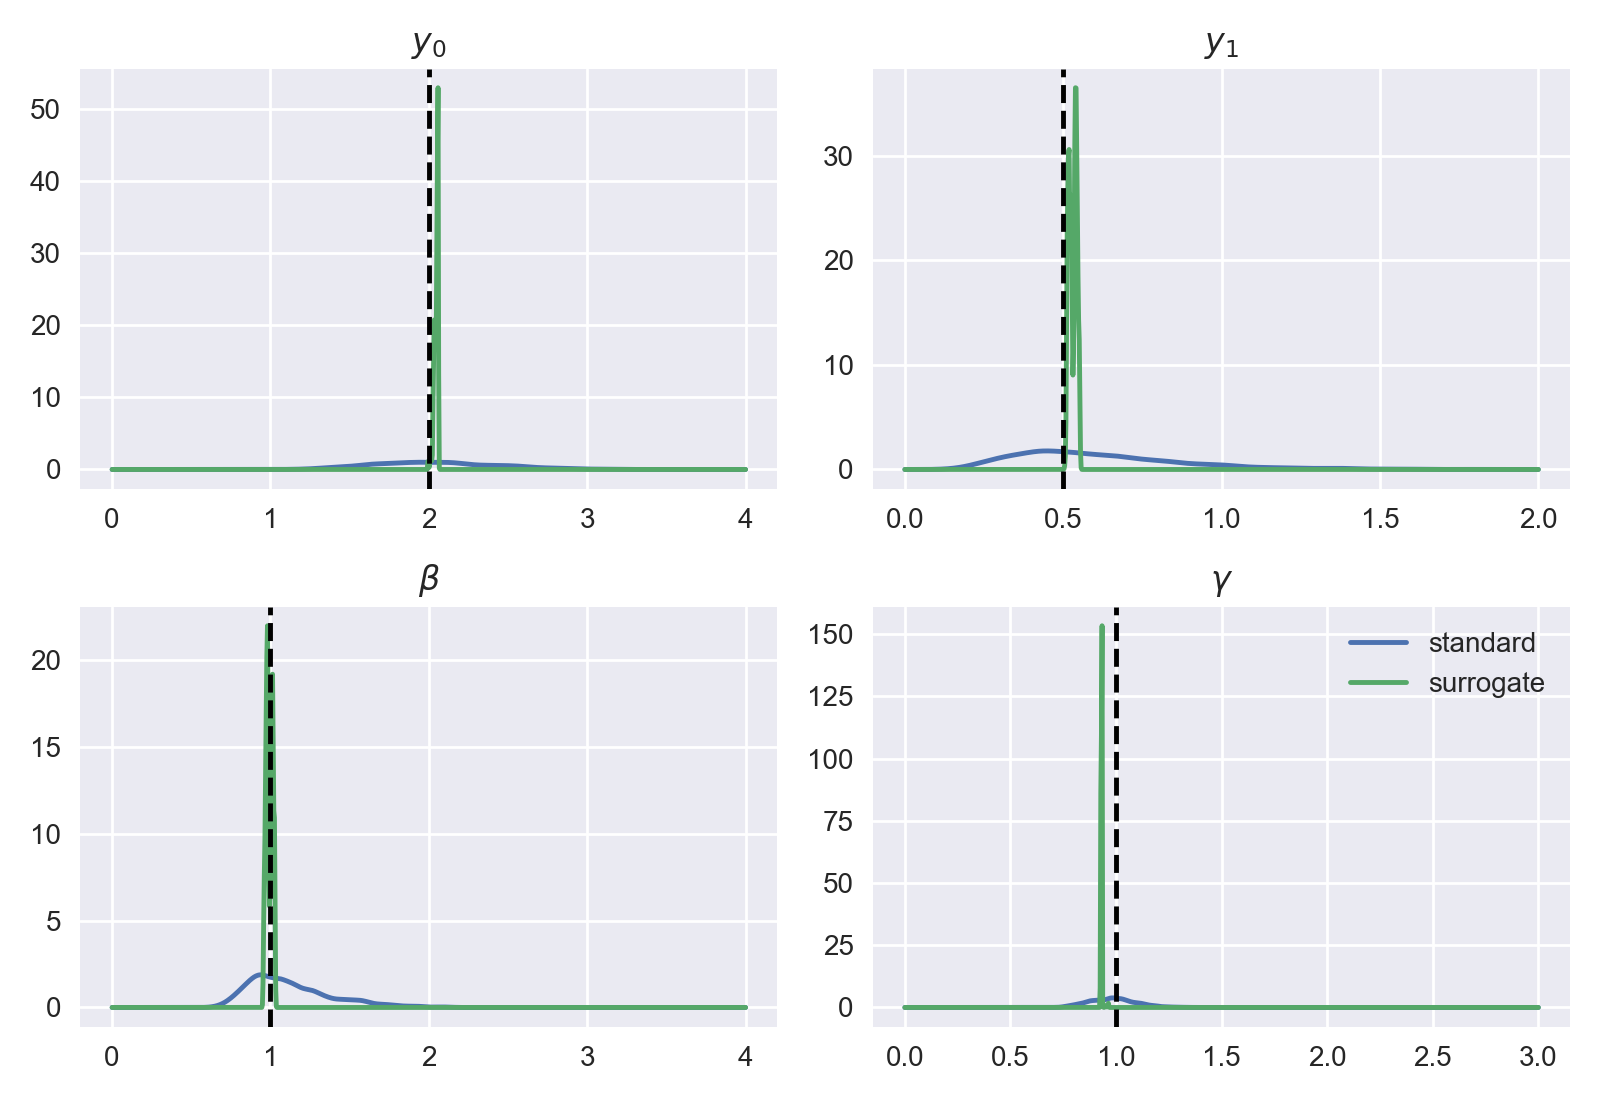

In [173]:
fig = plt.figure()
# y_o
plt.subplot(221)
x = np.linspace(0,4,1000)
plt.plot(x,kdes_std[0].pdf(x),label='standard')
plt.plot(x,kdes_sur[0].pdf(x),label='surrogate')
plt.axvline(2,ls='--',c='k')
plt.title("$y_0$")

# y_1
plt.subplot(222)
x = np.linspace(0,2,1000)
plt.plot(x,kdes_std[1].pdf(x),label='standard')
plt.plot(x,kdes_sur[1].pdf(x),label='surrogate')
plt.axvline(.5,ls='--',c='k')
plt.title("$y_1$")

# beta
plt.subplot(223)
x = np.linspace(0,4,1000)
plt.plot(x,kdes_std[2].pdf(x),label='standard')
plt.plot(x,kdes_sur[2].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$\\beta$")

# gamma
plt.subplot(224)
x = np.linspace(0,3,1000)
plt.plot(x,kdes_std[3].pdf(x),label='standard')
plt.plot(x,kdes_sur[3].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$\\gamma$")


plt.tight_layout()
plt.legend()
plt.show()

# SIR Model

In [192]:
def SIR(t,y,beta,gamma):
    dy = np.empty_like(y)
    dy[0] = -beta*y[1]*y[0]
    dy[1] = beta*y[1]*y[0] - gamma*y[1]
    dy[2] = gamma*y[1]
    return dy

In [193]:
def solve_SIR(T,y0,beta,gamma):
    sol = solve_ivp(SIR,(T[0],T[-1]),y0,t_eval=T,args=(beta,gamma))
    return sol.y

In [194]:
# choose true parameters
y0 = [.99,.01,0]
beta = 30
gamma = 10

# generate simulated data
T = np.linspace(0,1,10)
y = solve_SIR(T,y0,beta,gamma)

# add noise
sigma = 0.02
y_noisy = np.abs(y + sigma*np.random.randn(y.shape[0],y.shape[1]))

<IPython.core.display.Javascript object>


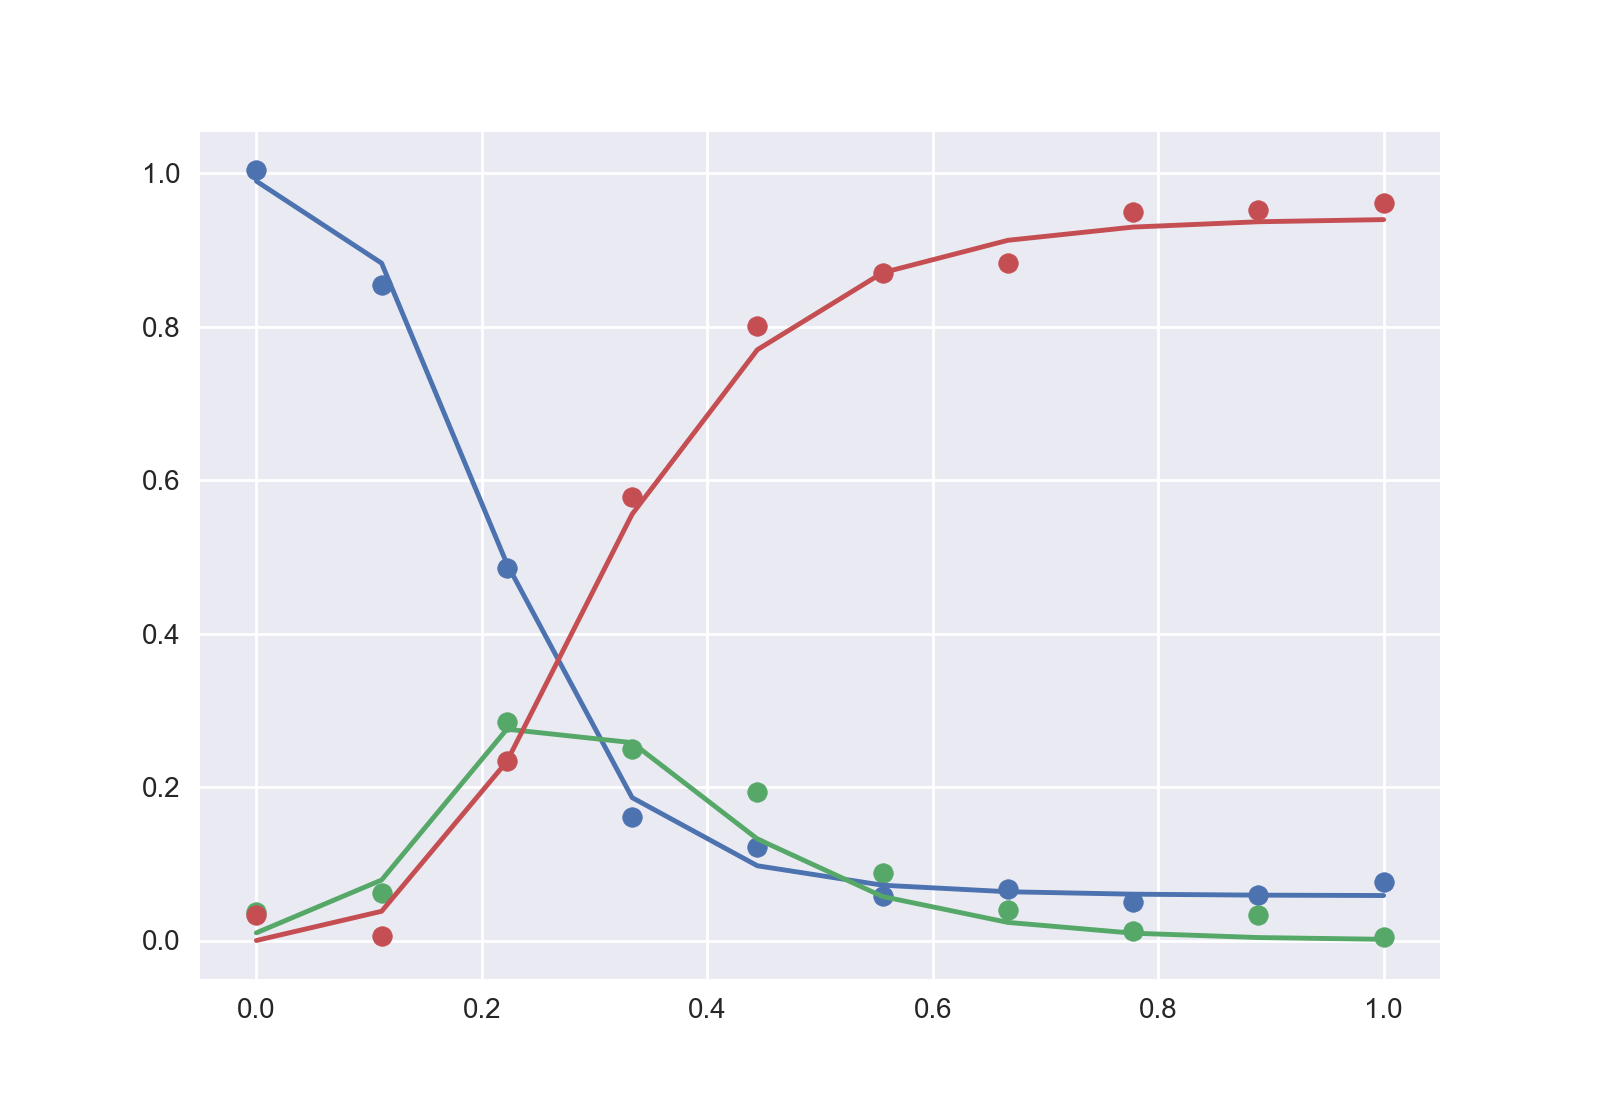

In [195]:
fig = plt.figure()
plt.plot(T,y[0])
plt.plot(T,y[1])
plt.plot(T,y[2])
plt.scatter(T,y_noisy[0])
plt.scatter(T,y_noisy[1])
plt.scatter(T,y_noisy[2])
plt.show()

In [196]:
# define likelihood and prior
# gaussian likelihood
def llh_std(y):
    return -((y-y_noisy)**2).sum()

# uniform prior
def lpr_std(x):
    if (0<x[0]<.1) and (0<x[1]<100) and (0<x[2]<100):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_std(x):
    y0 = np.zeros(3)
    y0[0] = 1-x[0]
    y0[1] = x[0]
    return solve_SIR(T,y0,x[1],x[2])

In [197]:
# sample
x0 = np.array([y_noisy[1,0],30,10])
cov = 0.01*np.eye(3)
X_std = rw_metropolis_hastings(f_std,llh_std,lpr_std,cov,x0,n=10000,burn_in=1000,update=False,verbose=False)

acceptance rate: 0.3353


In [198]:
kdes_std = []
for col in X_std.T:
    kdes_std.append(gaussian_kde(col))

<IPython.core.display.Javascript object>


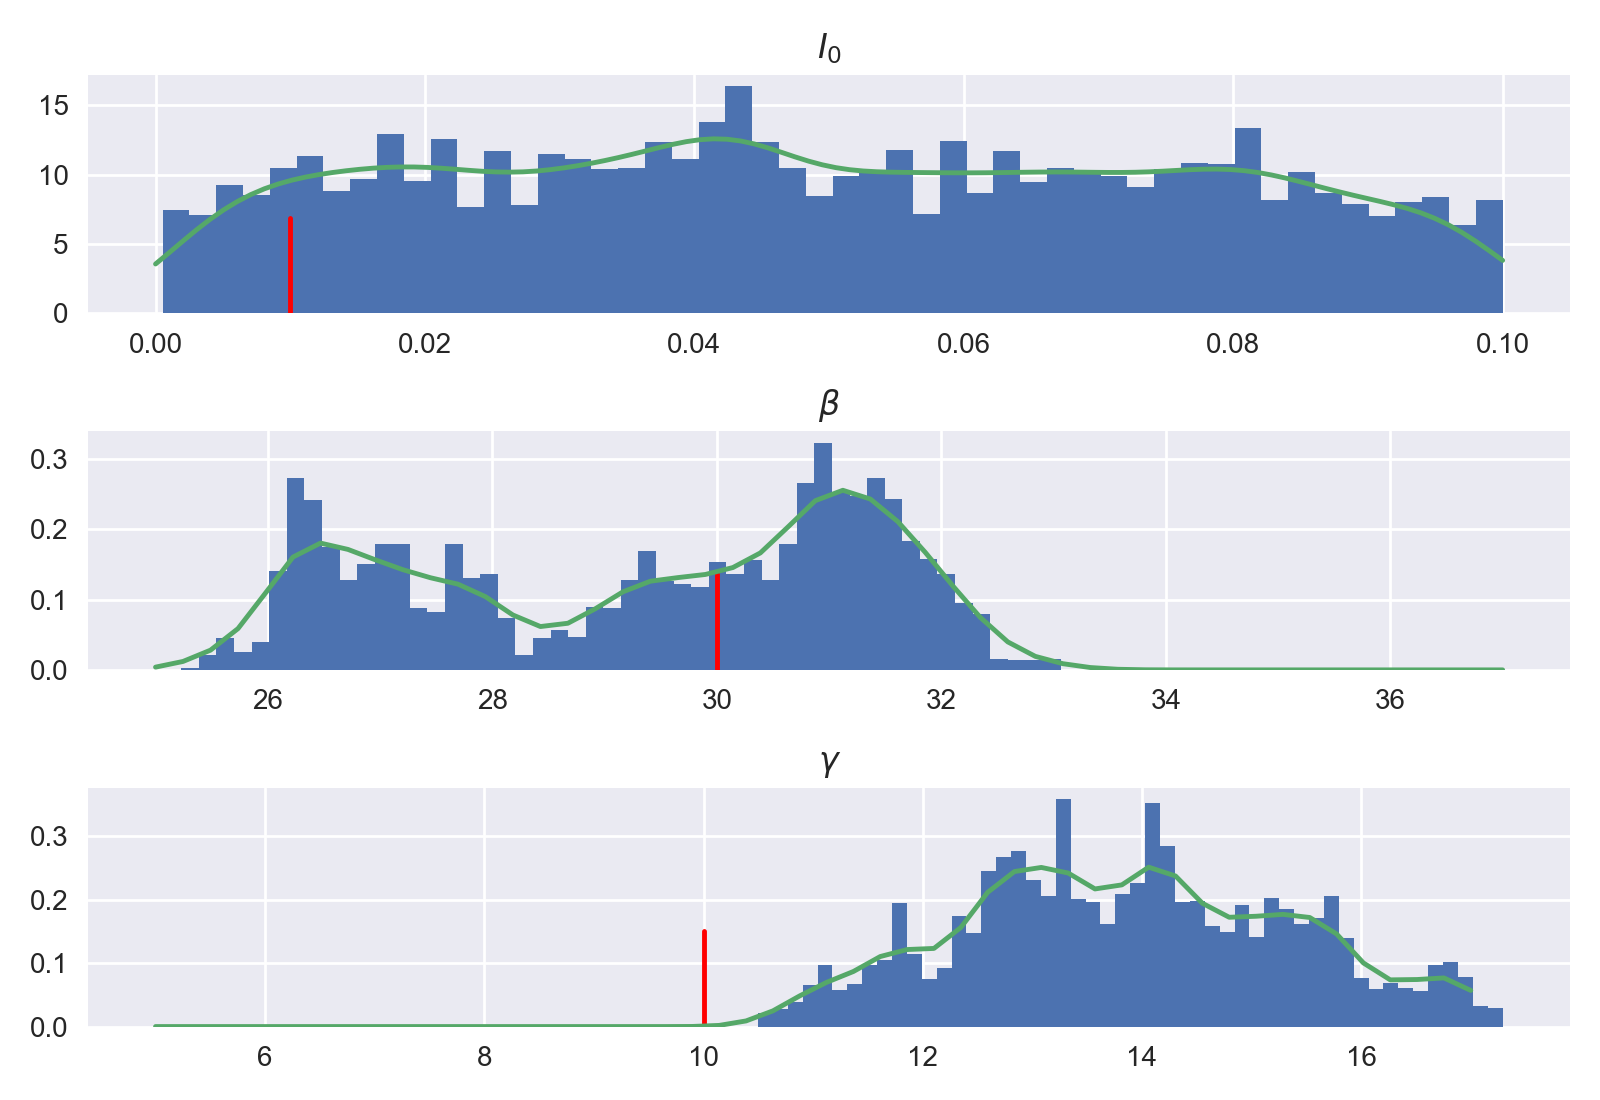

In [199]:
fig = plt.figure()
x = np.linspace(0,.1,100)
plt.subplot(311)
plt.hist(X_std[:,0],bins=50,density=True)
plt.axvline(y0[1],ymax=.4,c='r')
plt.plot(x,kdes_std[0].pdf(x),c='C1')
plt.title('$I_0$')

plt.subplot(312)
x = np.linspace(25,37)
plt.hist(X_std[:,1],bins=50,density=True)
plt.axvline(beta,ymax=.4,c='r')
plt.plot(x,kdes_std[1].pdf(x),c='C1')
plt.title('$\\beta$')

plt.subplot(313)
x = np.linspace(5,17)
plt.hist(X_std[:,2],bins=50,density=True)
plt.axvline(gamma,ymax=.4,c='r')
plt.plot(x,kdes_std[2].pdf(x),c='C1')
plt.title('$\\gamma$')


plt.tight_layout()
plt.show()

In [220]:
# fit GPs to noisy data
kernel1 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel(noise_level=.02,noise_level_bounds=(.02,.02))
kernel2 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel(noise_level=.02,noise_level_bounds=(.02,.02))
kernel3 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel(noise_level=.02,noise_level_bounds=(.02,.02))
y1_gp = gp.GaussianProcessRegressor(kernel1)
y2_gp = gp.GaussianProcessRegressor(kernel2)
y3_gp = gp.GaussianProcessRegressor(kernel3)
y1_gp = y1_gp.fit(T[:,np.newaxis],y_noisy[0])
y2_gp = y2_gp.fit(T[:,np.newaxis],y_noisy[1])
y3_gp = y3_gp.fit(T[:,np.newaxis],y_noisy[2])

/Users/hringer/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.02. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/hringer/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.02. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/hringer/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.02. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The 

In [221]:
# define high-res time points for evaluation
T_sur = np.linspace(0,1,201)

# compute mean and covariance of GPs
mean1,cov1 = y1_gp.predict(T_sur[:,np.newaxis],return_cov=True)
mean2,cov2 = y2_gp.predict(T_sur[:,np.newaxis],return_cov=True)
mean3,cov3 = y3_gp.predict(T_sur[:,np.newaxis],return_cov=True)

# compute eigendecompositions
e1,v1 = la.eig(cov1)
e2,v2 = la.eig(cov2)
e3,v3 = la.eig(cov3)

# build weight matrices
W1 = np.sqrt(1/e1)@(v1.T)
W2 = np.sqrt(1/e2)@(v2.T)
W3 = np.sqrt(1/e3)@(v3.T)

In [222]:
# high res simulation
y_hr = solve_SIR(T_sur,y0,30,10)

<IPython.core.display.Javascript object>


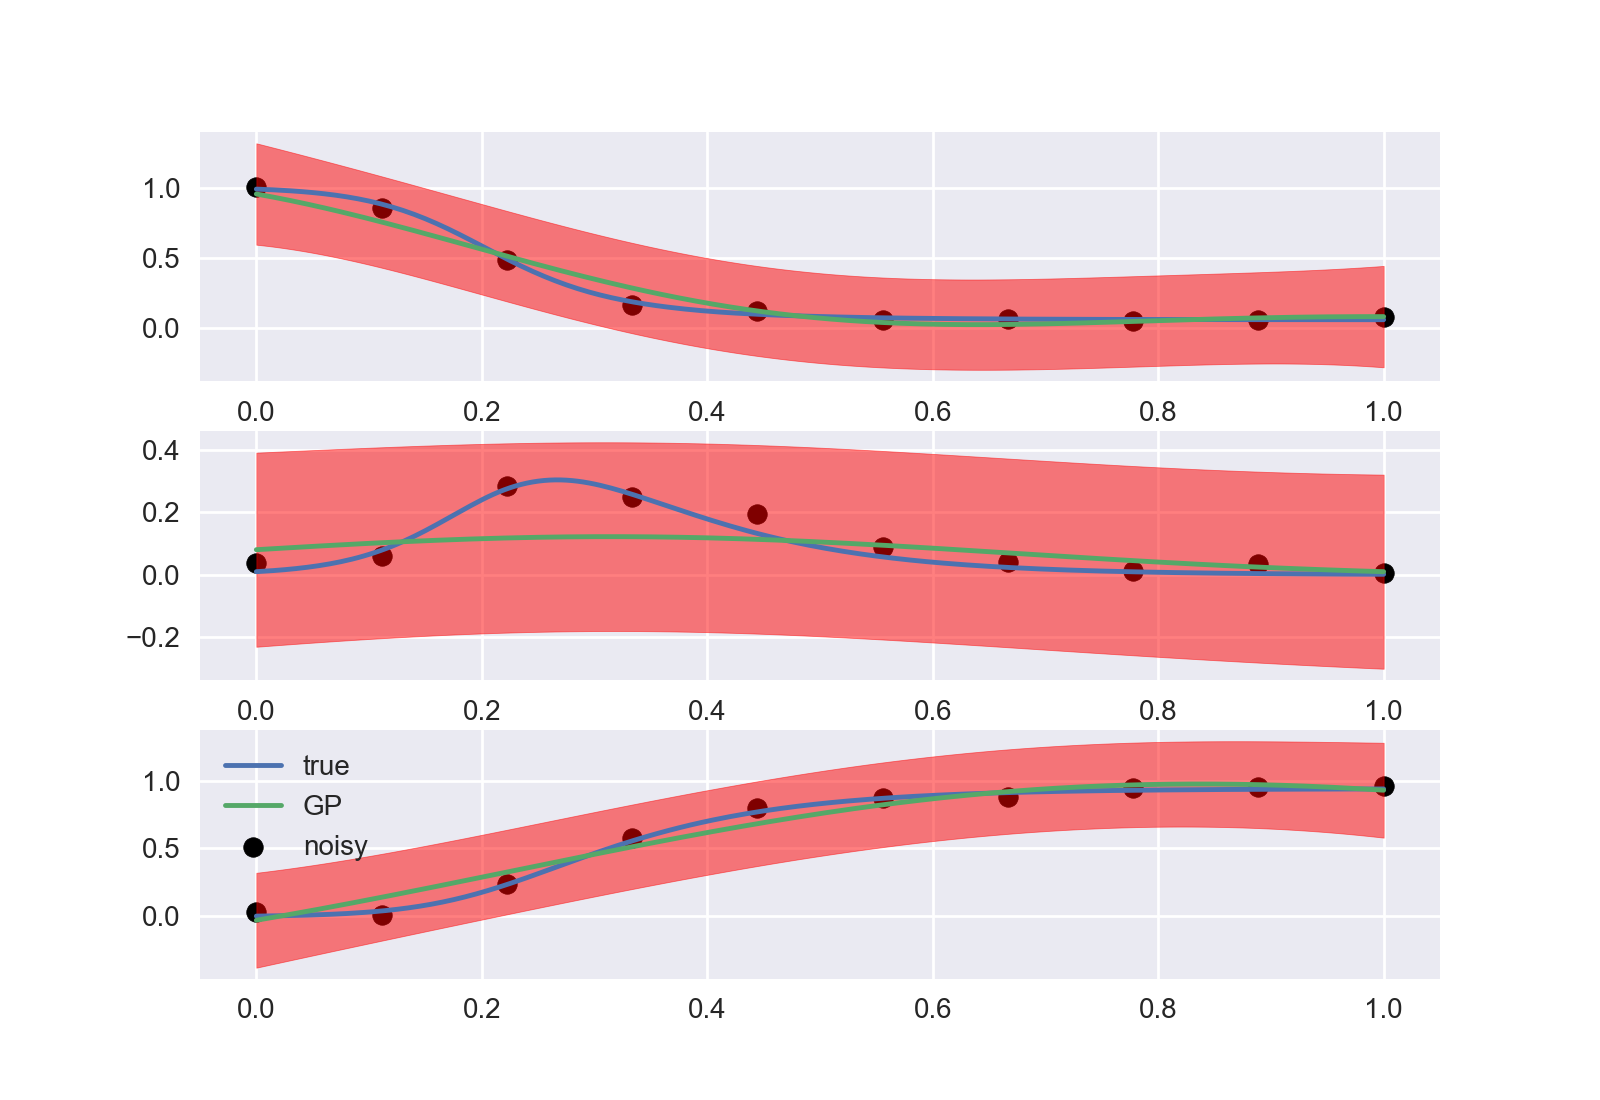

In [223]:
fig = plt.figure()
plt.subplot(311)
plt.plot(T_sur,y_hr[0],label='true')
plt.scatter(T,y_noisy[0],c='k',label='noisy')
plt.plot(T_sur,mean1,label='GP')
plt.fill_between(T_sur,mean1-2*np.sqrt(np.diag(cov1)),mean1+2*np.sqrt(np.diag(cov1)),color='r',alpha=.5)
plt.subplot(312)
plt.plot(T_sur,y_hr[1],label='true')
plt.scatter(T,y_noisy[1],c='k',label='noisy')
plt.plot(T_sur,mean2,label='GP')
plt.fill_between(T_sur,mean2-2*np.sqrt(np.diag(cov2)),mean2+2*np.sqrt(np.diag(cov2)),color='r',alpha=.5)
plt.subplot(313)
plt.plot(T_sur,y_hr[2],label='true')
plt.scatter(T,y_noisy[2],c='k',label='noisy')
plt.plot(T_sur,mean3,label='GP')
plt.fill_between(T_sur,mean3-2*np.sqrt(np.diag(cov3)),mean3+2*np.sqrt(np.diag(cov3)),color='r',alpha=.5)
plt.legend()
plt.show()

In [224]:
# define likelihood and prior
# gaussian likelihood
def llh_sur(y):
    return -la.norm(W1@(y[0]-mean1))**2 - la.norm(W2@(y[1]-mean2))**2 - la.norm(W3@(y[1]-mean3))**2

# uniform prior
def lpr_sur(x):
    if (0<x[0]<.1) and (0<x[1]<100) and (0<x[2]<100):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_sur(x):
    y0 = np.zeros(3)
    y0[0] = 1-x[0]
    y0[1] = x[0]
    return solve_SIR(T_sur,y0,x[1],x[2])

In [227]:
# sample
x0 = np.array([y_noisy[1,0],20,10])
cov = .0001*np.diag([.1,30,10])
X_sur = rw_metropolis_hastings(f_sur,llh_sur,lpr_sur,cov,x0,n=10000,burn_in=1000,update=False,verbose=False)

acceptance rate: 0.0616


In [228]:
kdes_sur = []
for col in X_sur.T:
    kdes_sur.append(gaussian_kde(col))

<IPython.core.display.Javascript object>


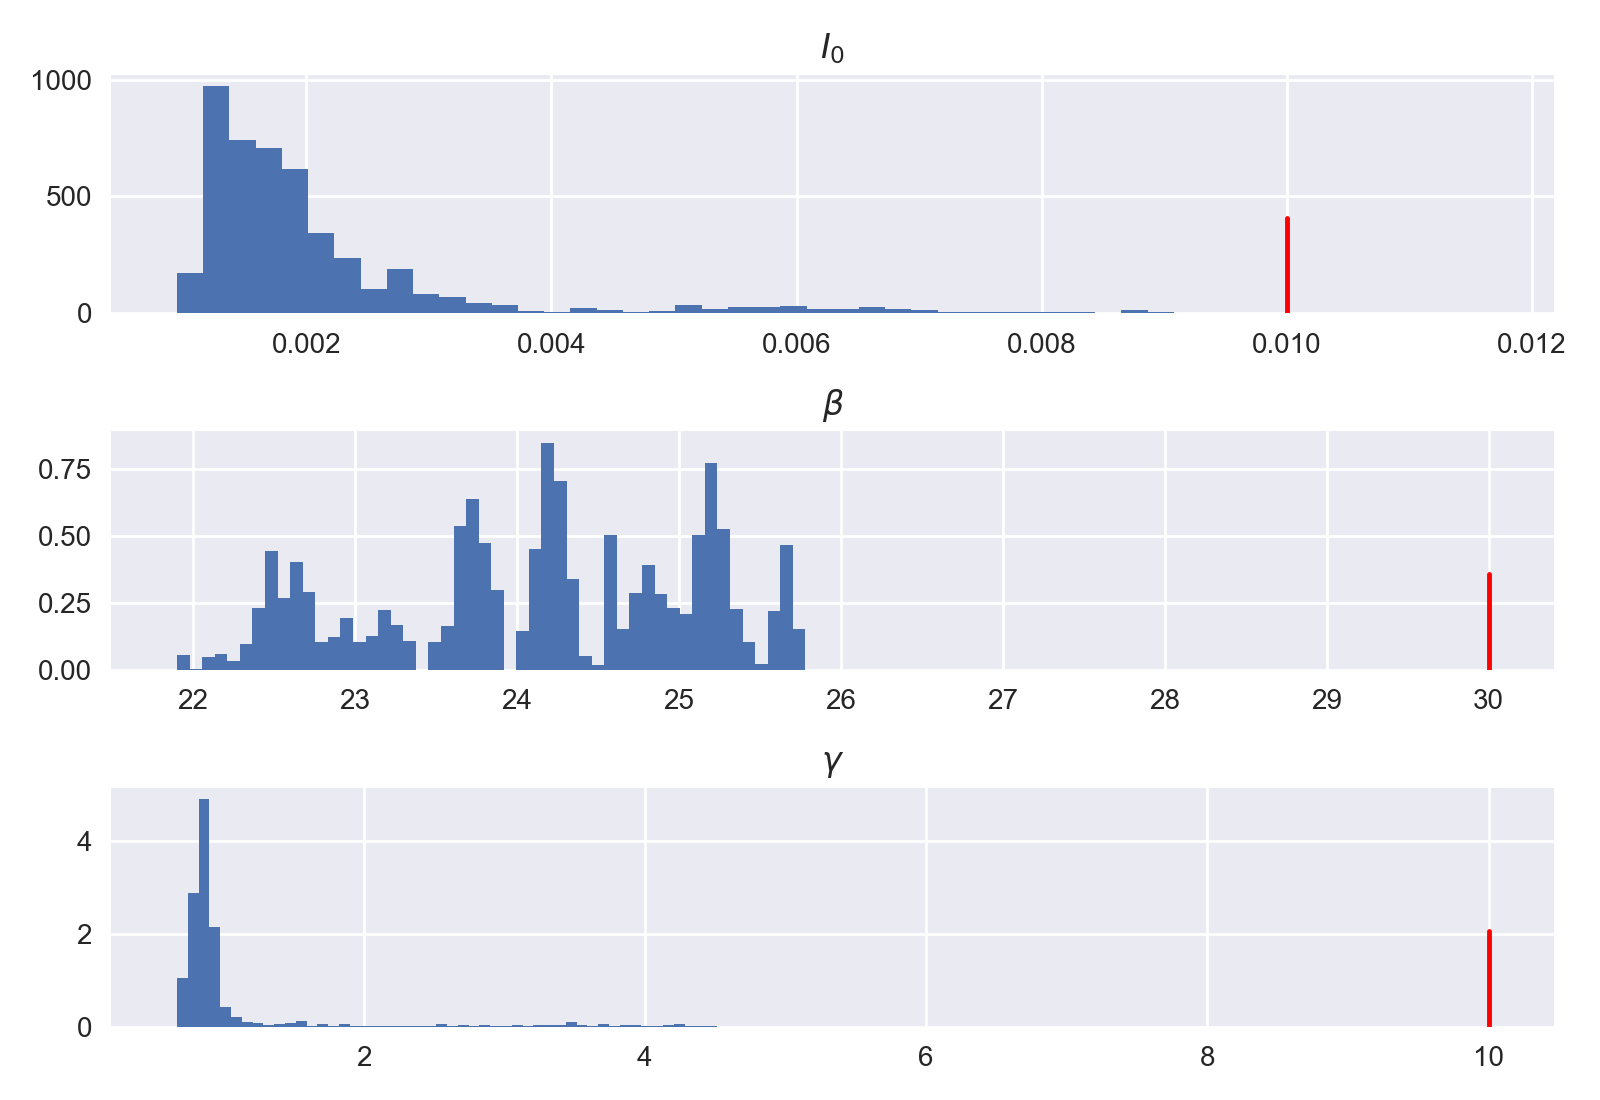

In [229]:
fig = plt.figure()
plt.subplot(311)
plt.hist(X_sur[:,0],bins=50,density=True)
plt.axvline(y0[1],ymax=.4,c='r')
plt.title('$I_0$')

plt.subplot(312)
plt.hist(X_sur[:,1],bins=50,density=True)
plt.axvline(beta,ymax=.4,c='r')
plt.title('$\\beta$')

plt.subplot(313)
plt.hist(X_sur[:,2],bins=50,density=True)
plt.axvline(gamma,ymax=.4,c='r')
plt.title('$\\gamma$')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


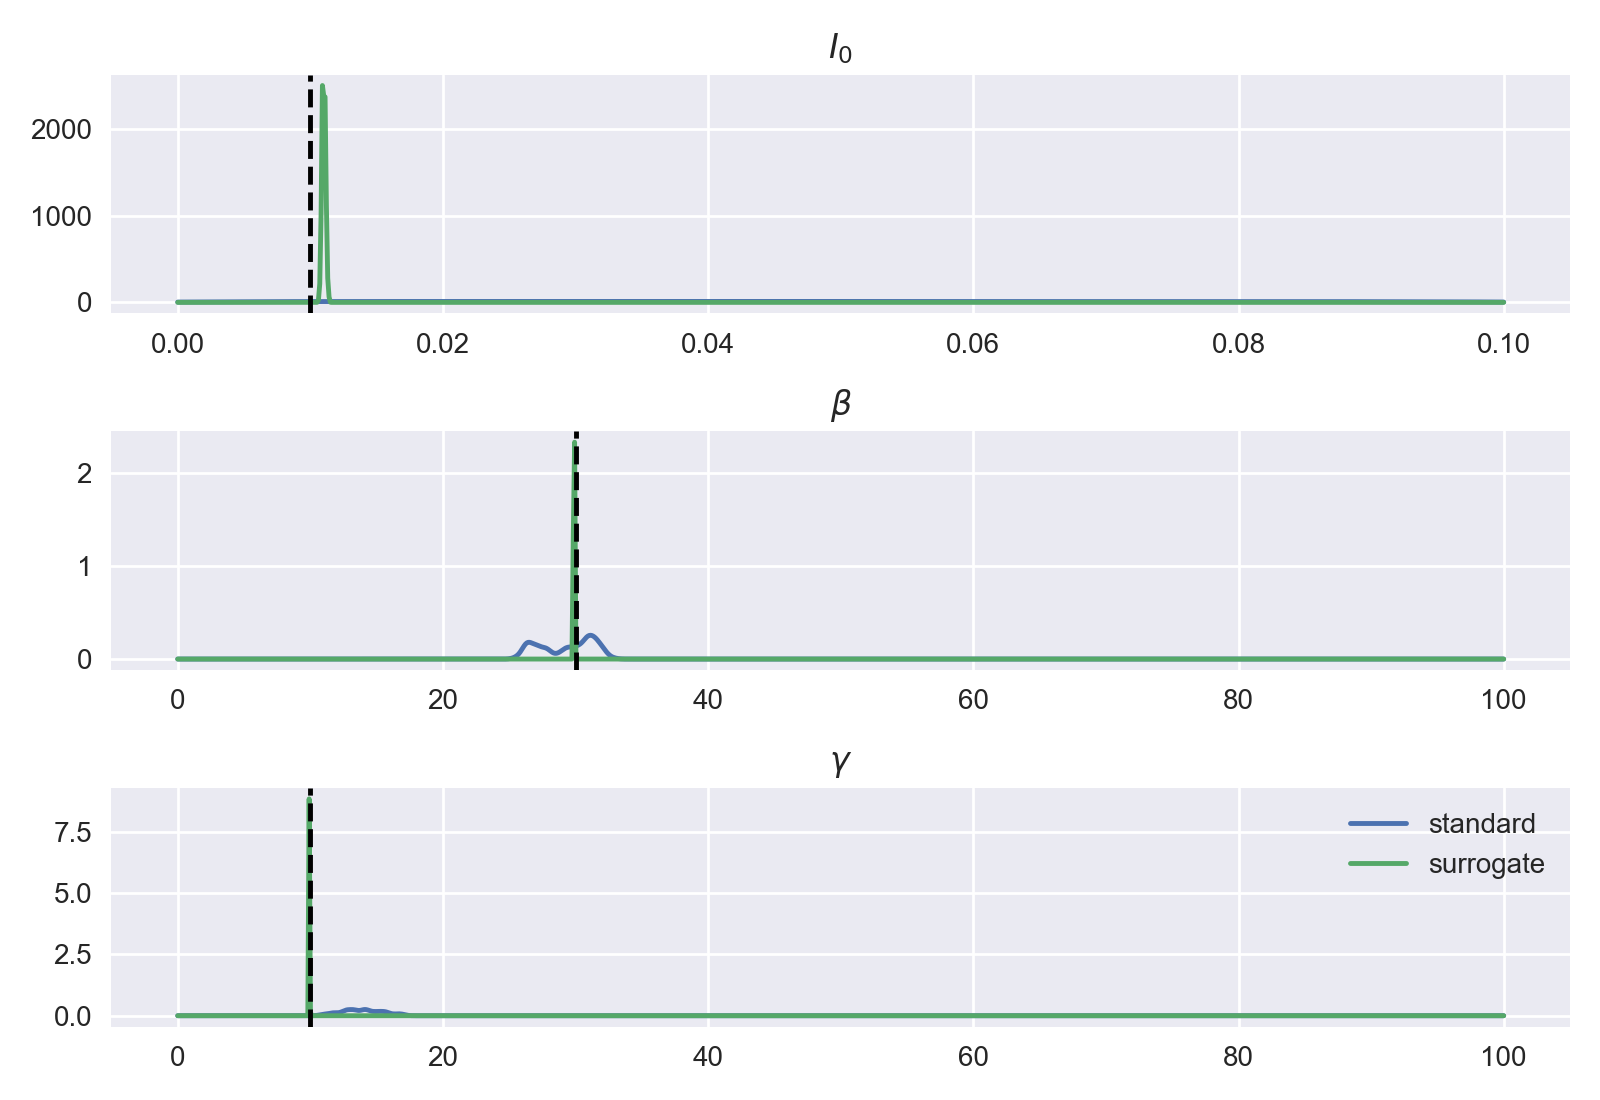

In [200]:
fig = plt.figure()
# y_o
plt.subplot(311)
x = np.linspace(0,.1,1000)
plt.plot(x,kdes_std[0].pdf(x),label='standard')
plt.plot(x,kdes_sur[0].pdf(x),label='surrogate')
plt.axvline(.01,ls='--',c='k')
plt.title("$I_0$")

# y_1
plt.subplot(312)
x = np.linspace(0,100,1000)
plt.plot(x,kdes_std[1].pdf(x),label='standard')
plt.plot(x,kdes_sur[1].pdf(x),label='surrogate')
plt.axvline(30,ls='--',c='k')
plt.title("$\\beta$")

# beta
plt.subplot(313)
x = np.linspace(0,100,1000)
plt.plot(x,kdes_std[2].pdf(x),label='standard')
plt.plot(x,kdes_sur[2].pdf(x),label='surrogate')
plt.axvline(10,ls='--',c='k')
plt.title("$\\gamma$")

plt.tight_layout()
plt.legend()
plt.show()

# Lorenz System

In [74]:
def lorenz(t,y,beta,sigma,rho):
    dy = np.empty_like(y)
    dy[0] = sigma*(y[1]-y[0])
    dy[1] = y[0]*(rho-y[2])-y[1]
    dy[2] = y[0]*y[1]-beta*y[2]
    return dy

In [75]:
def solve_lorenz(T,y0,beta,sigma,rho):
    sol = solve_ivp(lorenz,(T[0],T[-1]),y0,t_eval=T,args=(beta,sigma,rho))
    return sol.y

In [104]:
# choose true parameters
y0 = [1,1,1]
beta = 8/3
sigma = 10
rho = 28

# generate simulated data
T = np.linspace(0,1,10)
y = solve_lorenz(T,y0,beta,sigma,rho)

# add noise
#sigma = .5
y_noisy = y #+ sigma*np.random.randn(y.shape[0],y.shape[1])

<IPython.core.display.Javascript object>


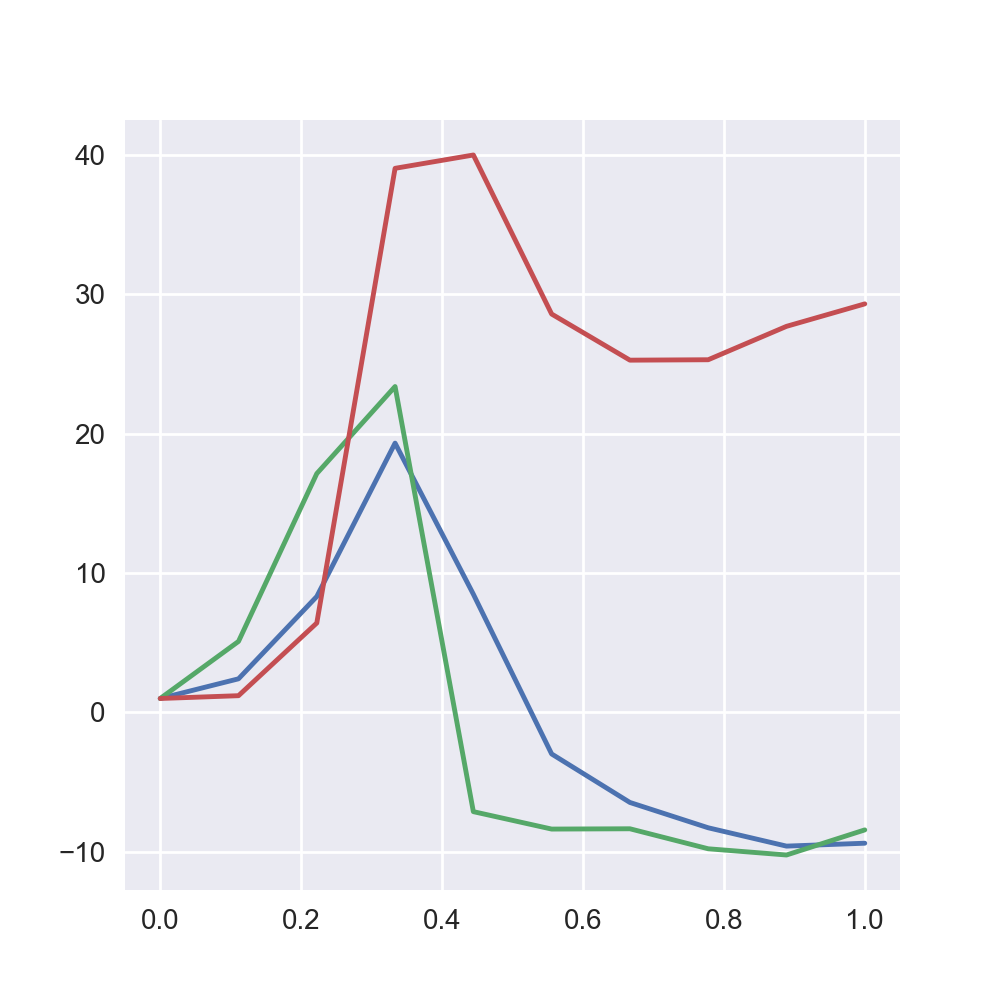

In [105]:
fig = plt.figure(figsize=(5,5))
plt.plot(T,y[0])
plt.plot(T,y[1])
plt.plot(T,y[2])
# plt.plot(T_sur,y_hr[0])
# plt.plot(T_sur,y_hr[1])
# plt.plot(T_sur,y_hr[2])
# plt.scatter(T,y_noisy[0])
# plt.scatter(T,y_noisy[1])
# plt.scatter(T,y_noisy[2])
plt.show()

In [106]:
# define likelihood and prior
# gaussian likelihood
def llh_std(y):
    return -((y-y_noisy)**2).sum()

# uniform prior
def lpr_std(x):
    if (-10<x[0]<10) and (-10<x[1]<10) and (-10<x[2]<10):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_std(x):
    return solve_SIR(T,x,beta,sigma,rho)

In [107]:
# sample
x0 = np.array([1,1,1])
cov = 0.01*np.eye(3)
X_std = rw_metropolis_hastings(f_std,llh_std,lpr_std,cov,x0,n=10000,burn_in=1000,update=False,verbose=False)

acceptance rate: 0.2409


In [108]:
kdes_std = []
for col in X_std.T:
    kdes_std.append(gaussian_kde(col))

<IPython.core.display.Javascript object>


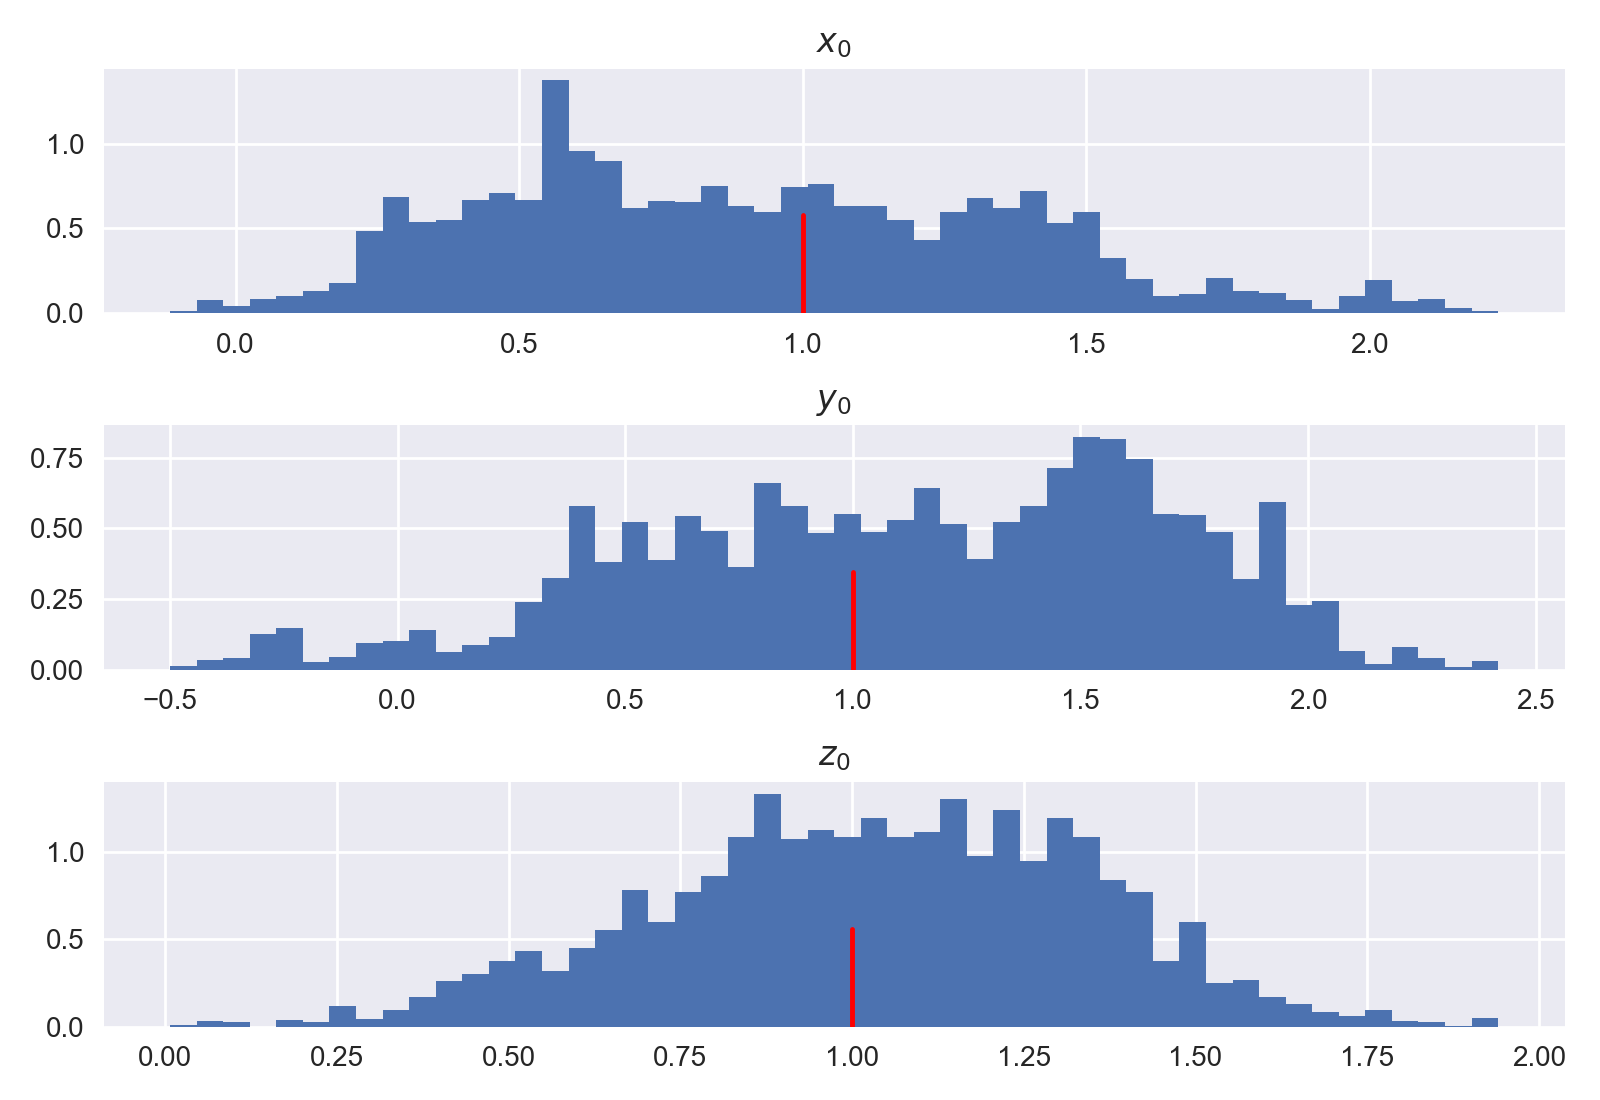

In [109]:
fig = plt.figure()
plt.subplot(311)
plt.hist(X_std[:,0],bins=50,density=True)
plt.axvline(1,ymax=.4,c='r')
plt.title('$x_0$')

plt.subplot(312)
plt.hist(X_std[:,1],bins=50,density=True)
plt.axvline(1,ymax=.4,c='r')
plt.title('$y_0$')

plt.subplot(313)
plt.hist(X_std[:,2],bins=50,density=True)
plt.axvline(1,ymax=.4,c='r')
plt.title('$z_0$')


plt.tight_layout()
plt.show()

In [132]:
# fit GPs to noisy data
kernel1 = 1000*gp.kernels.RBF(length_scale=.1) #+gp.kernels.WhiteKernel()
kernel2 = 1000*gp.kernels.RBF(length_scale=.1) #+gp.kernels.WhiteKernel()
kernel3 = 1000*gp.kernels.RBF(length_scale=.1) #+gp.kernels.WhiteKernel()
y1_gp = gp.GaussianProcessRegressor(kernel1,optimizer=None)
y2_gp = gp.GaussianProcessRegressor(kernel2,optimizer=None)
y3_gp = gp.GaussianProcessRegressor(kernel3,optimizer=None)
y1_gp = y1_gp.fit(T[:,np.newaxis],y_noisy[0])
y2_gp = y2_gp.fit(T[:,np.newaxis],y_noisy[1])
y3_gp = y3_gp.fit(T[:,np.newaxis],y_noisy[2])

In [133]:
# define high-res time points for evaluation
T_sur = np.linspace(0,1,201)

# compute mean and covariance of GPs
mean1,cov1 = y1_gp.predict(T_sur[:,np.newaxis],return_cov=True)
mean2,cov2 = y2_gp.predict(T_sur[:,np.newaxis],return_cov=True)
mean3,cov3 = y3_gp.predict(T_sur[:,np.newaxis],return_cov=True)

# compute eigendecompositions
e1,v1 = la.eig(cov1)
e2,v2 = la.eig(cov2)
e3,v3 = la.eig(cov3)

# build weight matrices
W1 = np.sqrt(1/e1)@(v1.T)
W2 = np.sqrt(1/e2)@(v2.T)
W3 = np.sqrt(1/e3)@(v3.T)

In [134]:
# choose true parameters
y0 = [1,1,1]
beta = 8/3
sigma = 10
rho = 28

# generate simulated data
y_hr = solve_lorenz(T_sur,y0,beta,sigma,rho)

<IPython.core.display.Javascript object>


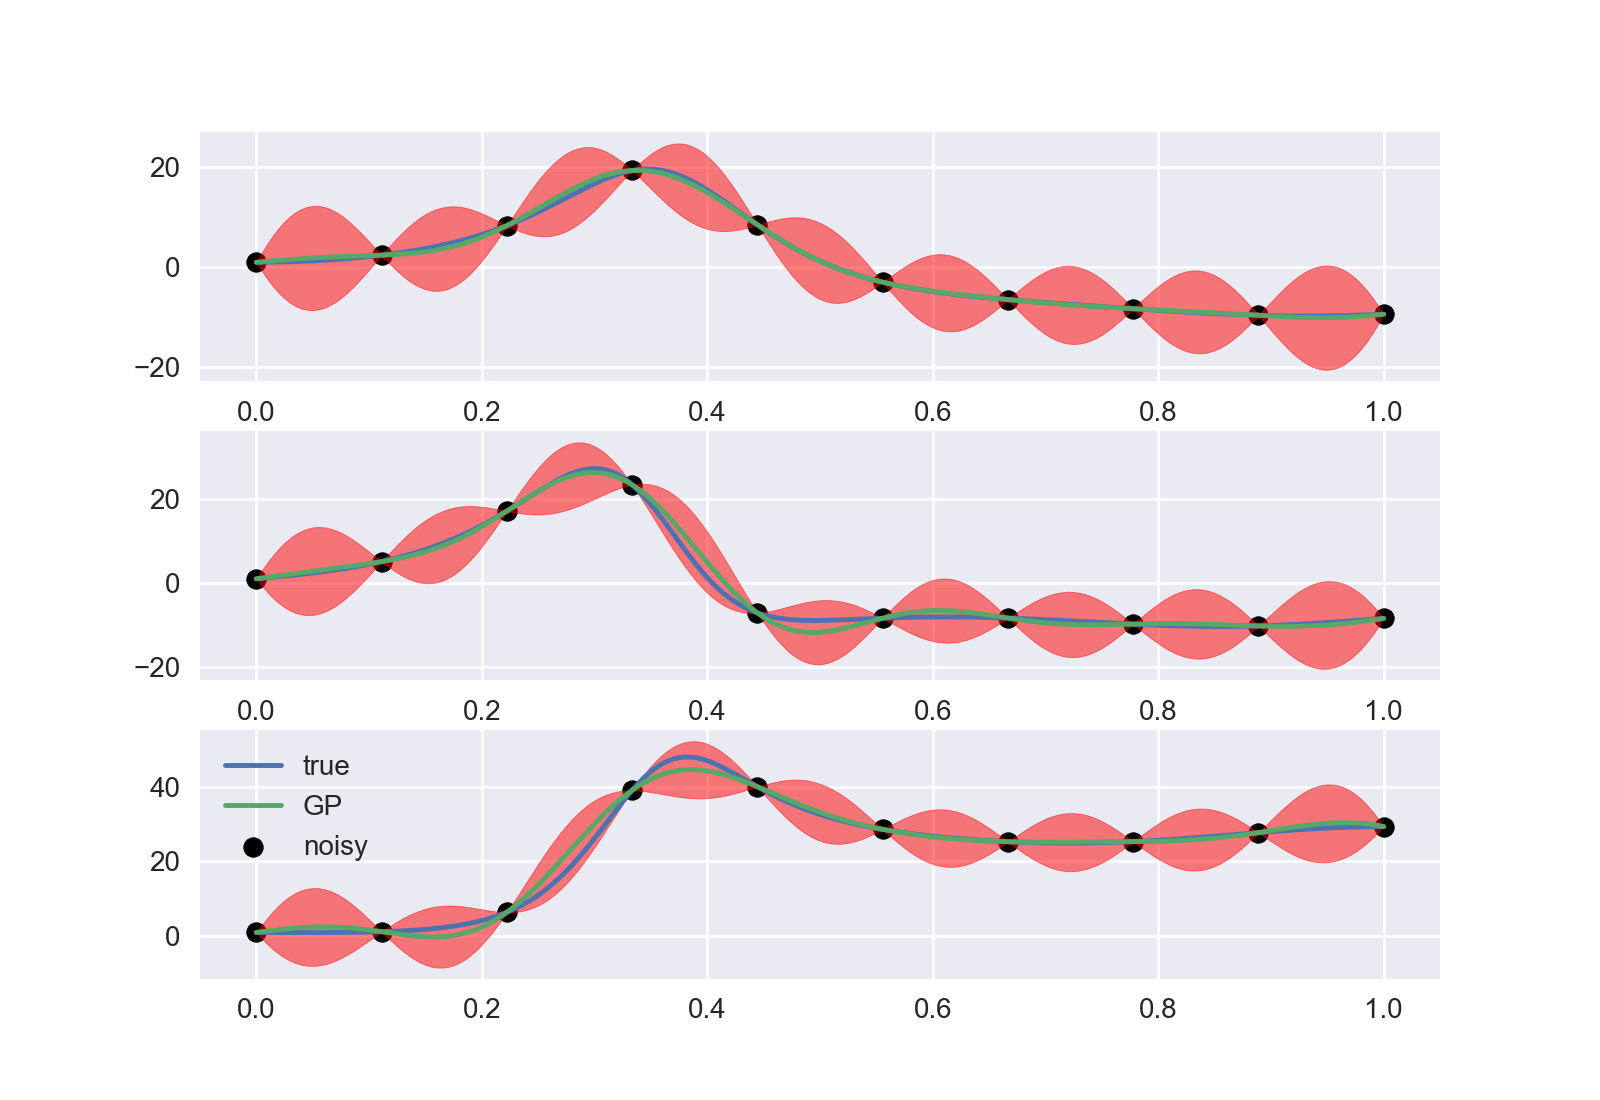

In [135]:
fig = plt.figure()
plt.subplot(311)
plt.plot(T_sur,y_hr[0],label='true')
plt.scatter(T,y_noisy[0],c='k',label='noisy')
plt.plot(T_sur,mean1,label='GP')
plt.fill_between(T_sur,mean1-2*np.sqrt(np.diag(cov1)),mean1+2*np.sqrt(np.diag(cov1)),color='r',alpha=.5)
plt.subplot(312)
plt.plot(T_sur,y_hr[1],label='true')
plt.scatter(T,y_noisy[1],c='k',label='noisy')
plt.plot(T_sur,mean2,label='GP')
plt.fill_between(T_sur,mean2-2*np.sqrt(np.diag(cov2)),mean2+2*np.sqrt(np.diag(cov2)),color='r',alpha=.5)
plt.subplot(313)
plt.plot(T_sur,y_hr[2],label='true')
plt.scatter(T,y_noisy[2],c='k',label='noisy')
plt.plot(T_sur,mean3,label='GP')
plt.fill_between(T_sur,mean3-2*np.sqrt(np.diag(cov3)),mean3+2*np.sqrt(np.diag(cov3)),color='r',alpha=.5)
plt.legend()
plt.show()

In [138]:
# define likelihood and prior
# gaussian likelihood
def llh_sur(y):
    return -la.norm(W1@(y[0]-mean1))**2 - la.norm(W2@(y[1]-mean2))**2 - la.norm(W3@(y[1]-mean3))**2

# uniform prior
def lpr_sur(x):
    if (-10<x[0]<10) and (-10<x[1]<10) and (-10<x[2]<10):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_sur(x):
    return solve_SIR(T_sur,x,beta,sigma,rho)

In [145]:
# sample
x0 = np.array([1,1,1])
cov = 0.00000002*np.eye(3)
X_sur = rw_metropolis_hastings(f_sur,llh_sur,lpr_sur,cov,x0,n=10000,burn_in=1000,update=False,verbose=False)

acceptance rate: 0.1121


In [146]:
kdes_sur = []
for col in X_sur.T:
    kdes_sur.append(gaussian_kde(col))

<IPython.core.display.Javascript object>


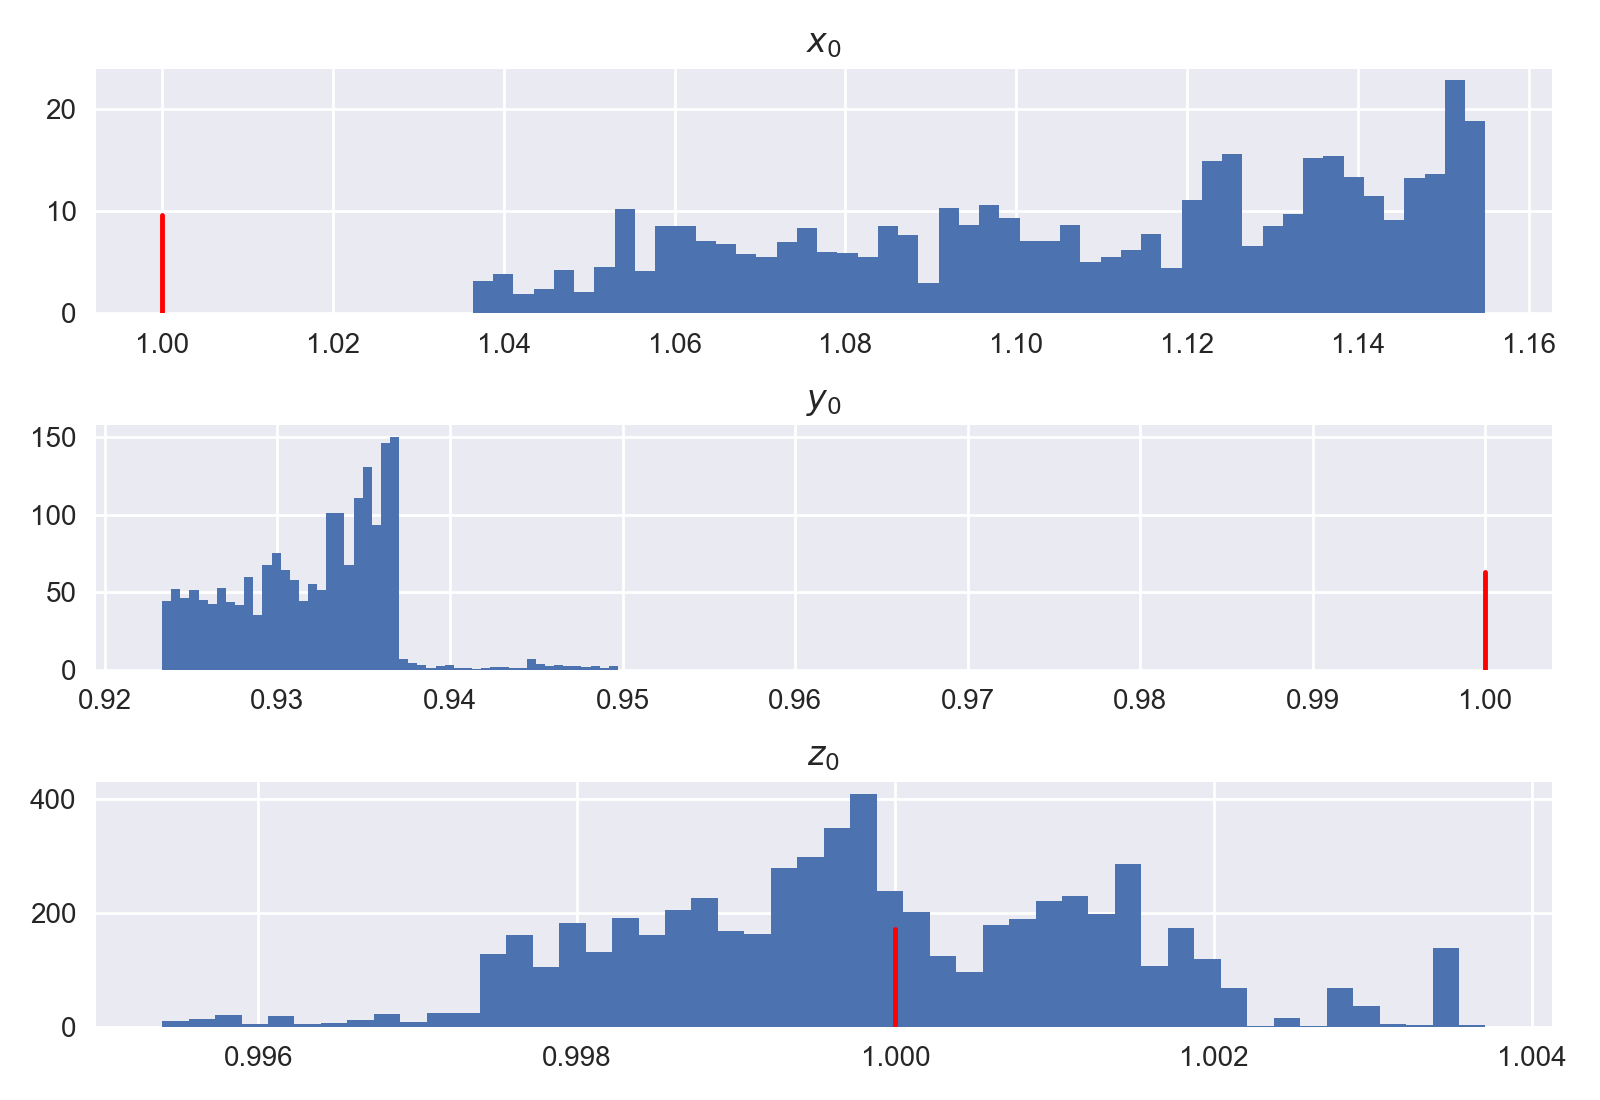

In [147]:
fig = plt.figure()
plt.subplot(311)
plt.hist(X_sur[:,0],bins=50,density=True)
plt.axvline(1,ymax=.4,c='r')
plt.title('$x_0$')

plt.subplot(312)
plt.hist(X_sur[:,1],bins=50,density=True)
plt.axvline(1,ymax=.4,c='r')
plt.title('$y_0$')

plt.subplot(313)
plt.hist(X_sur[:,2],bins=50,density=True)
plt.axvline(1,ymax=.4,c='r')
plt.title('$z_0$')


plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


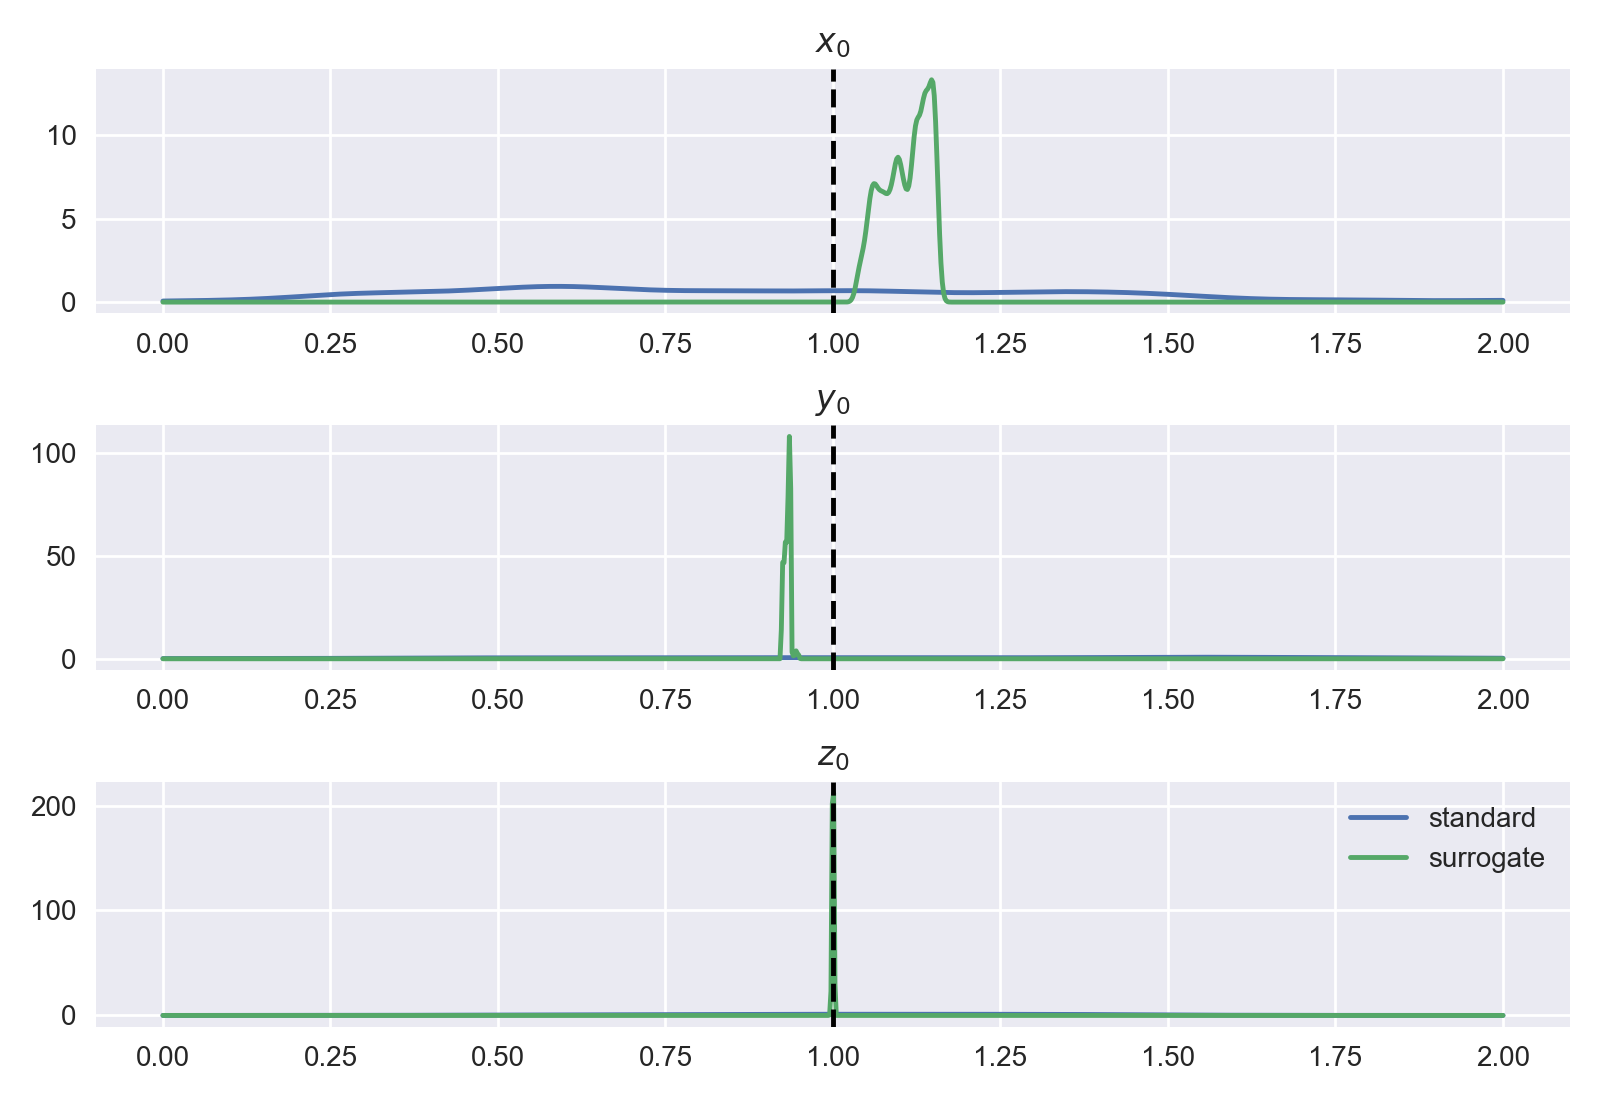

In [151]:
fig = plt.figure()
# y_o
plt.subplot(311)
x = np.linspace(0,2,1000)
plt.plot(x,kdes_std[0].pdf(x),label='standard')
plt.plot(x,kdes_sur[0].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$x_0$")

# y_1
plt.subplot(312)
x = np.linspace(0,2,1000)
plt.plot(x,kdes_std[1].pdf(x),label='standard')
plt.plot(x,kdes_sur[1].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$y_0$")

# beta
plt.subplot(313)
x = np.linspace(0,2,1000)
plt.plot(x,kdes_std[2].pdf(x),label='standard')
plt.plot(x,kdes_sur[2].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$z_0$")

plt.tight_layout()
plt.legend()
plt.show()

## Inverse Heat Problem

In [87]:
def solve_1dheat(t,x,u0,lbc,rbc,c):
    U = np.zeros((t.shape[0],x.shape[0]))
    U[0] = u0
    U[:,0],U[:,-1] = lbc,rbc
    dx = x[1]-x[0]
    dt = t[1]-t[0]
    lambda_ = c*(dt/dx**2)
    if lambda_ > .5:
        print(f"lambda = {lambda_} > .5")
    
    for i in range(1,len(t)):
        U[i,1:-1] = U[i-1,1:-1] + lambda_*(U[i-1,:-2]-2*U[i-1,1:-1]+U[i-1,2:])
    
    return U

<IPython.core.display.Javascript object>


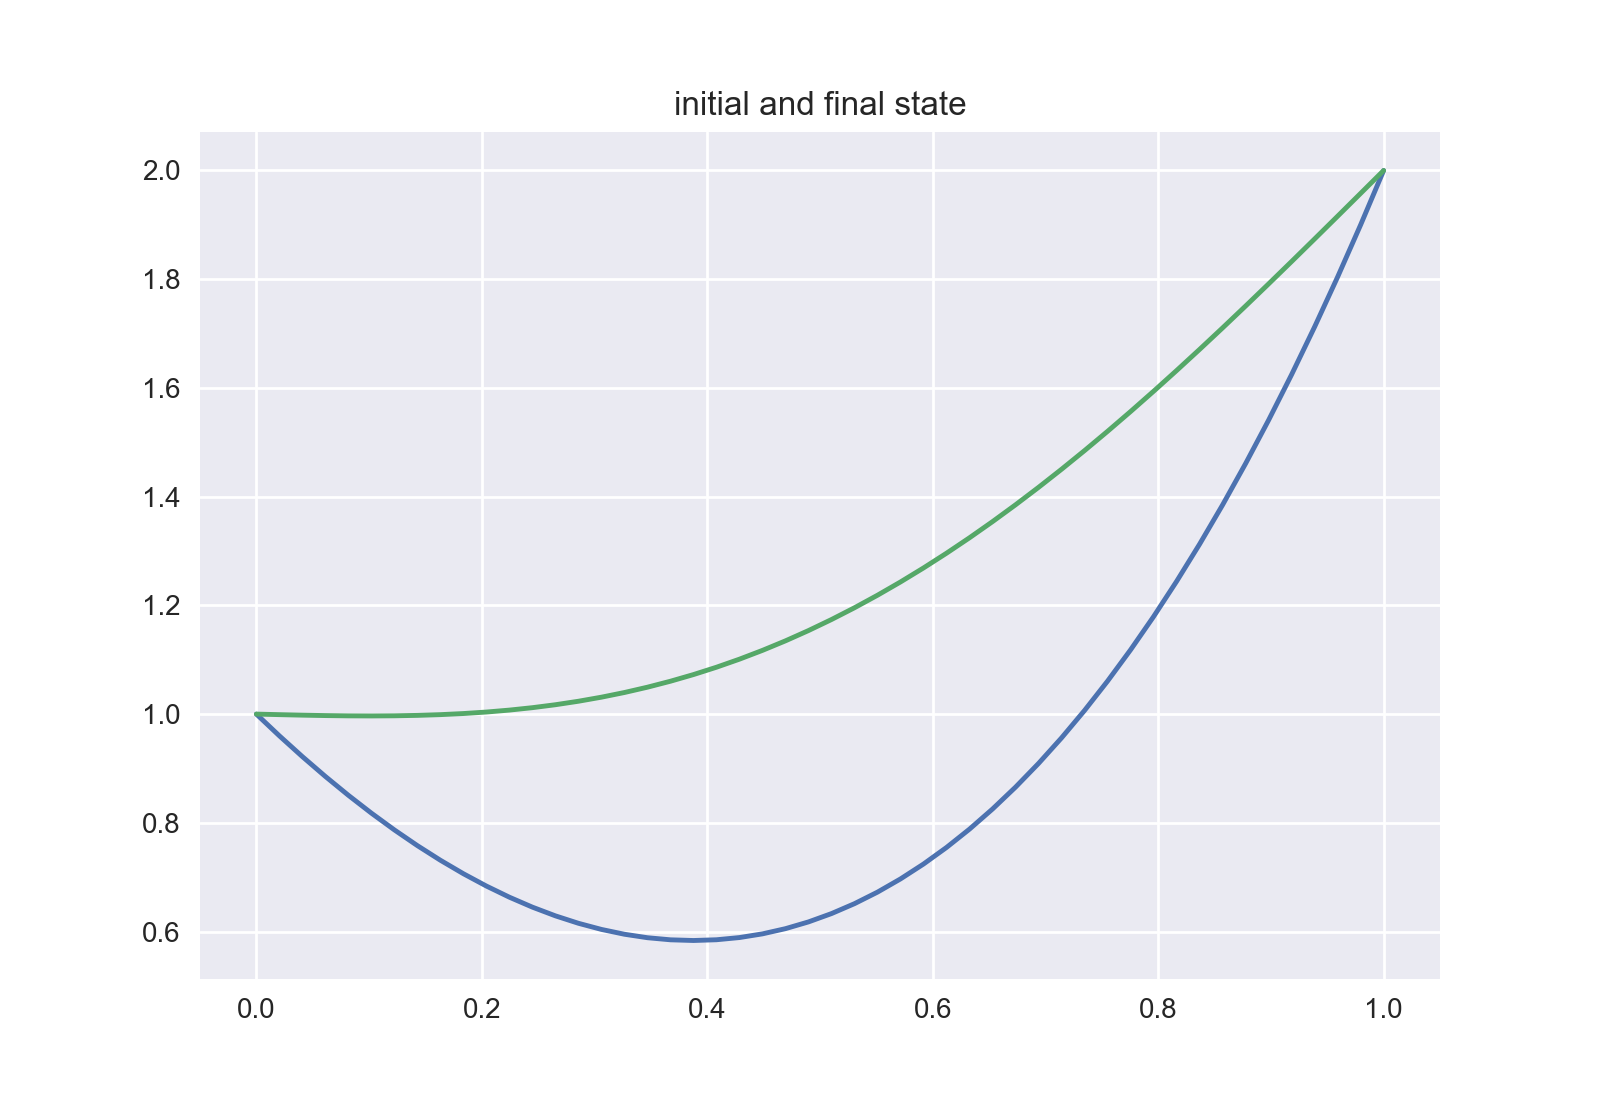

In [88]:
c = [1,2,-2,1]
x = np.linspace(0,1)
u0 = c[0]*x**3+c[1]*x**2+c[2]*x+c[3]
fig = plt.figure()
plt.plot(x,u0)
plt.title('initial and final state')


t = np.linspace(0,1,500)
U = solve_1dheat(t,x,u0,u0[0],u0[-1],.1)
plt.plot(x,U[-1])

plt.show()

In [89]:
# get noisy data
c = [1,2,-2,1]
x_obs = np.linspace(0,1,10)
u0 = c[0]*x_obs**3+c[1]*x_obs**2+c[2]*x_obs+c[3]
t_obs = np.linspace(0,1,20)
U_noisy = solve_1dheat(t_obs,x_obs,u0,u0[0],u0[-1],.1)
sigma = 0.02
U_noisy += sigma*np.random.randn(U_noisy.shape[0],U_noisy.shape[1])

In [93]:
def llh_heat_std(U):
    return -((U[-1]-U_noisy[-1])**2).sum()/(2*sigma**2)
    
def lpr_heat_std(c):
    return 0

In [94]:
def f_heat_std(c):
    u0 = c[0]*x_obs**3+c[1]*x_obs**2+c[2]*x_obs+c[3]
    return solve_1dheat(t_obs,x_obs,u0,u0[0],u0[-1],.1)

In [97]:
c0 = [1,2,-2,1]
cov = np.diag((.02**2)*np.ones(4))
C_std = rw_metropolis_hastings(f_heat_std,llh_heat_std,lpr_heat_std,cov,c0,n=10000,burn_in=1000,update=False)

acceptance rate: 0.2038


<IPython.core.display.Javascript object>


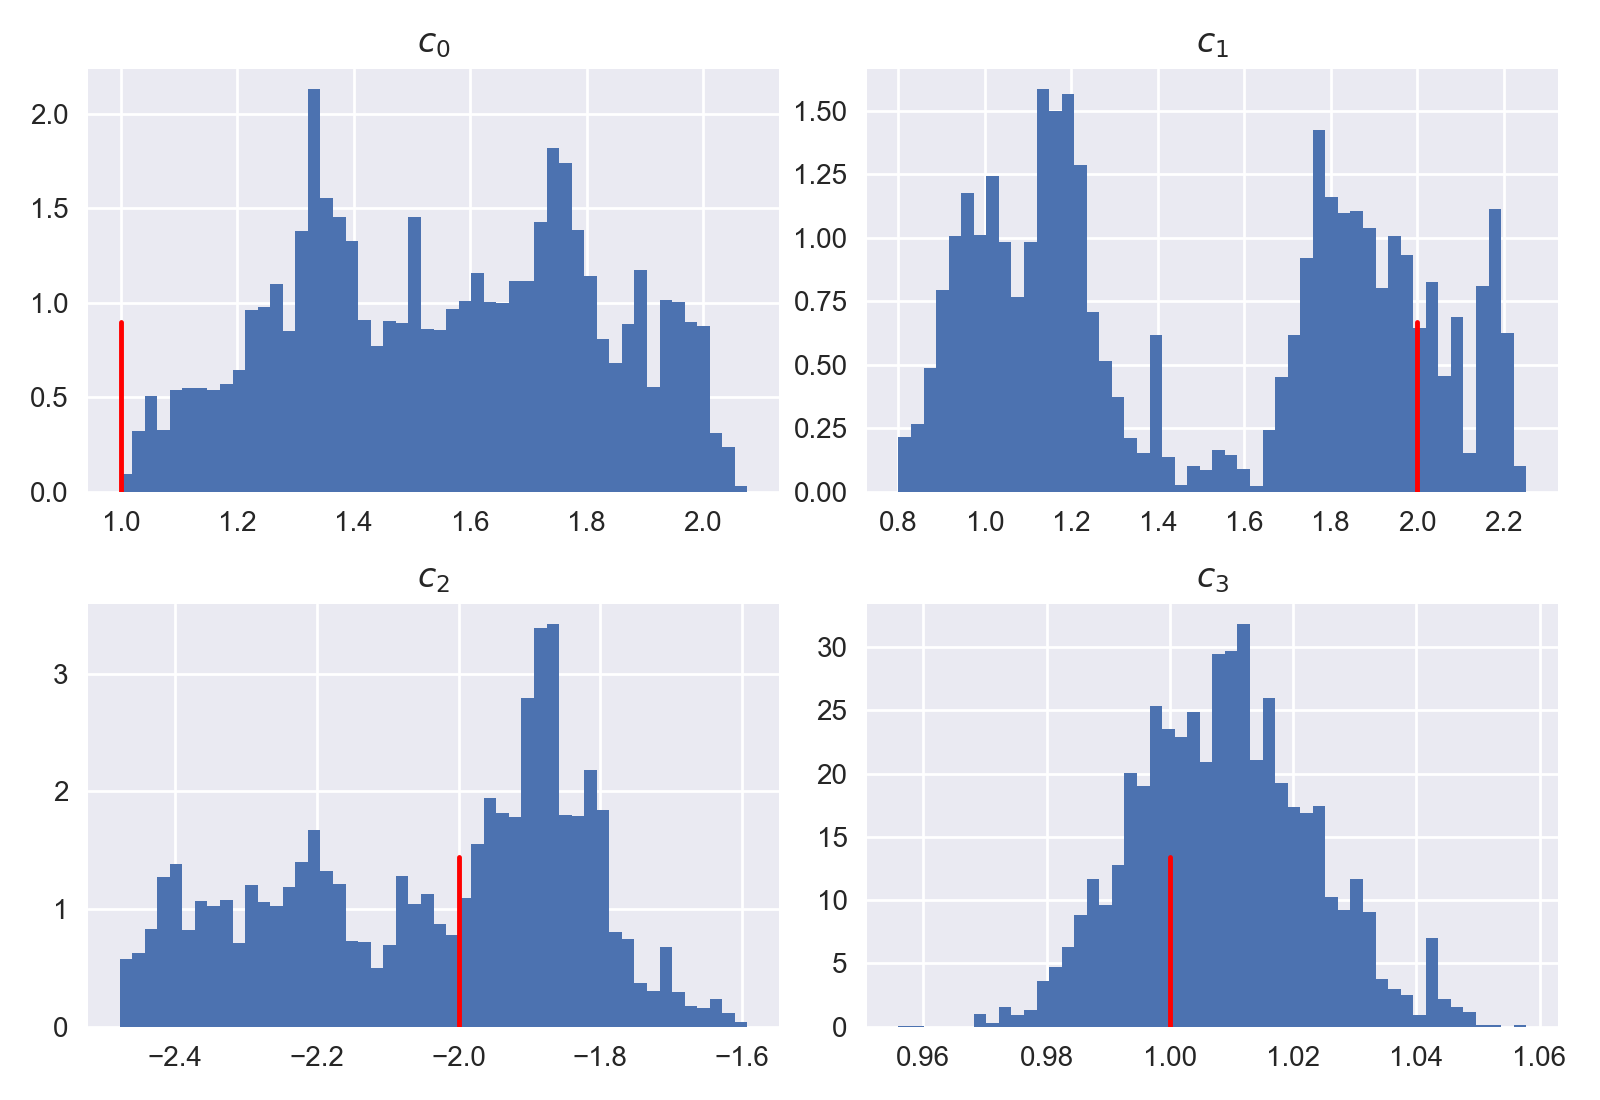

In [98]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(C_std[:,0],bins=50,density=True)
plt.axvline(c[0],ymax=.4,c='r')
plt.title('$c_0$')

plt.subplot(2,2,2)
plt.hist(C_std[:,1],bins=50,density=True)
plt.axvline(c[1],ymax=.4,c='r')
plt.title('$c_1$')

plt.subplot(2,2,3)
plt.hist(C_std[:,2],bins=50,density=True)
plt.axvline(c[2],ymax=.4,c='r')
plt.title('$c_2$')

plt.subplot(2,2,4)
plt.hist(C_std[:,3],bins=50,density=True)
plt.axvline(c[3],ymax=.4,c='r')
plt.title('$c_3$')

plt.tight_layout()
plt.show()

In [99]:
kdes_heat_std = []
for col in C_std.T:
    kdes_heat_std.append(gaussian_kde(col))

## Surrogate Data Inverse Heat

In [102]:
kernel = gp.kernels.RBF()+gp.kernels.WhiteKernel()
T_obs,X_obs = np.meshgrid(t_obs,x_obs,indexing='ij')
heat_gp = gp.GaussianProcessRegressor(kernel)
heat_gp = heat_gp.fit(np.array((T_obs.flatten(),X_obs.flatten())).T,U_noisy.flatten())

In [129]:
X_train = np.array((T_obs.flatten(),X_obs.flatten())).T
t_sur, x_sur = np.linspace(0,1,500),np.linspace(0,1,50)
T_sur, X_sur = np.meshgrid(t_sur,x_sur,indexing='ij')
X = np.array((T_sur.flatten(),X_sur.flatten())).T

In [130]:
# i = 25
# t_sur, x_sur = np.linspace(0,1,100),np.linspace(0,1,20)
# T_sur, X_sur = np.meshgrid(t_sur,x_sur,indexing='ij')

# t_sur_2 = t_sur[-i:]
# T_sur_2, X_sur_2 = np.meshgrid(t_sur_2,x_sur,indexing='ij')

# U_sur,cov = heat_gp.predict(np.array((T_sur_2.flatten(),X_sur_2.flatten())).T,ret_cov=True)
# U_sur = U_sur.reshape(T_sur_2.shape)
# L = la.cho_factor(cov)

In [131]:
U_sur,cov = heat_gp.predict(np.array((t_obs[-1]*np.ones_like(x_sur),x_sur)).T,return_cov=True)
L = la.cho_factor(cov)

In [132]:
def llh_heat_sur(U):
    return -(U[-1]-U_sur).flatten()@la.cho_solve(L,(U[-1]-U_sur).flatten())
    
def lpr_heat_sur(c):
    return 0

In [133]:
def f_heat_sur(c):
    u0 = c[0]*x_sur**3+c[1]*x_sur**2+c[2]*x_sur+c[3]
    return solve_1dheat(t_sur,x_sur,u0,u0[0],u0[-1],.1)

In [135]:
c0 = [1,2,-2,1]
cov = np.diag((.01**2)*np.ones(4))
C_sur = rw_metropolis_hastings(f_heat_sur,llh_heat_sur,lpr_heat_sur,cov,c0,n=10000,burn_in=1000,update=False)

acceptance rate: 0.2592


<IPython.core.display.Javascript object>


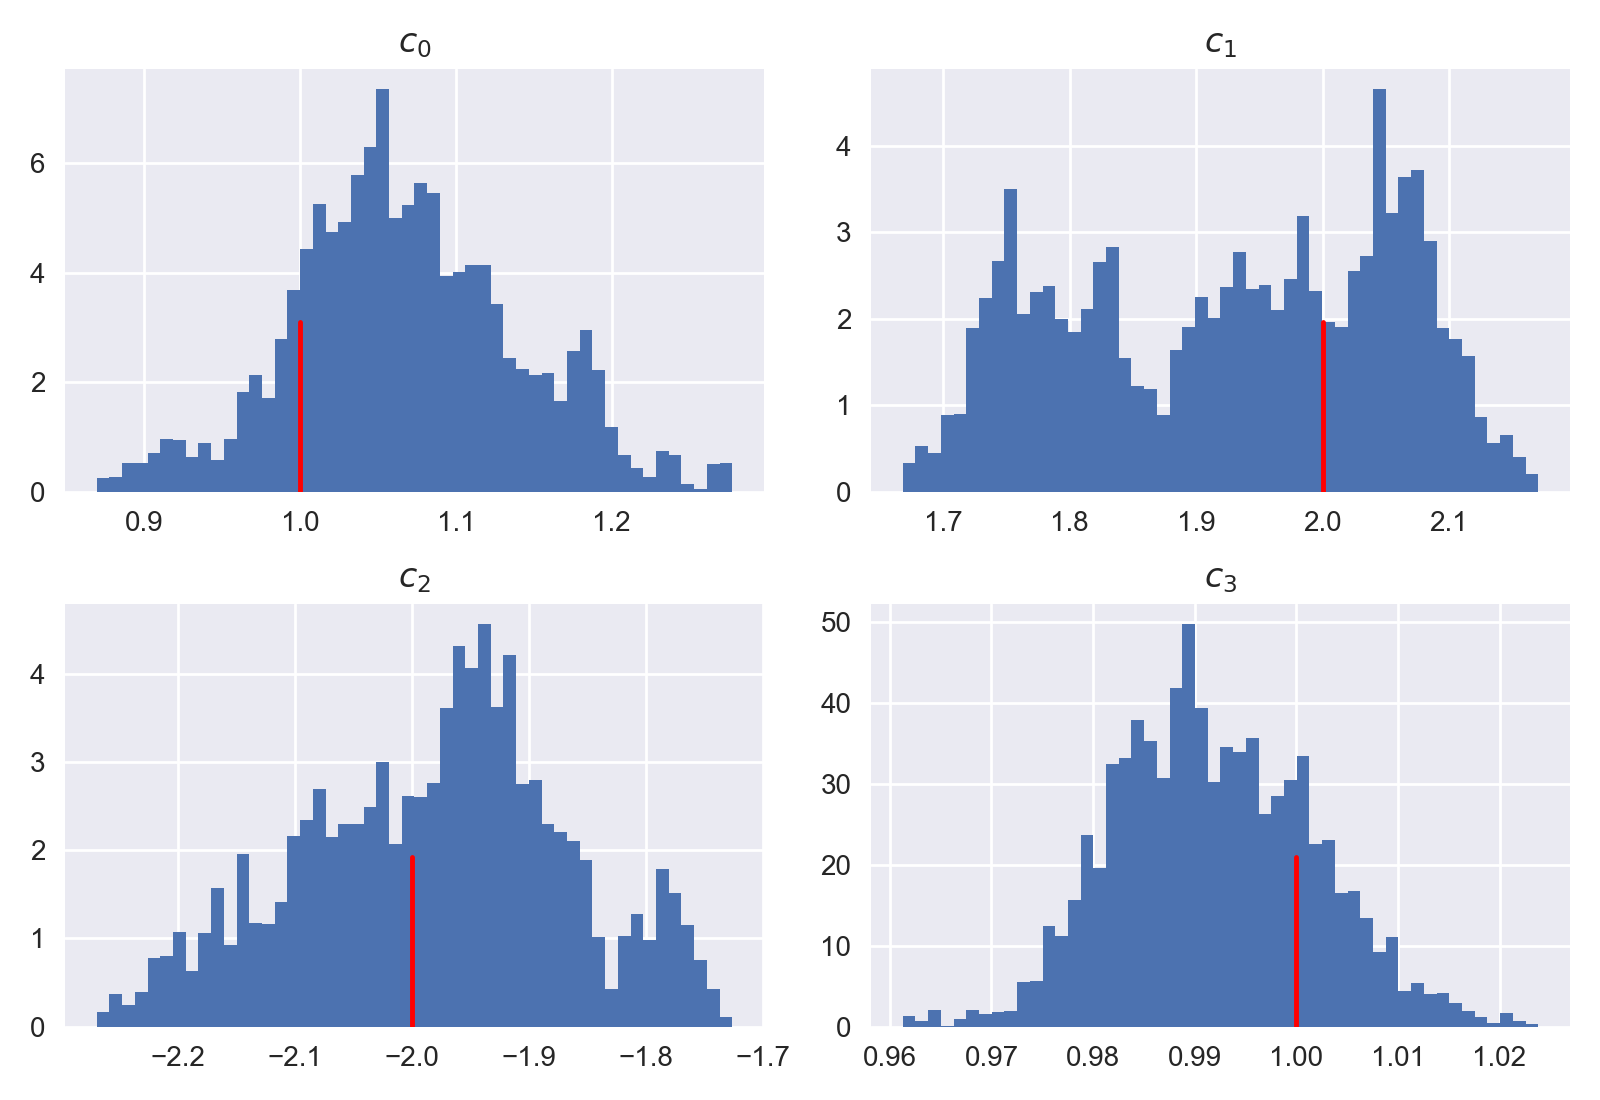

In [136]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(C_sur[:,0],bins=50,density=True)
plt.axvline(c[0],ymax=.4,c='r')
plt.title('$c_0$')

plt.subplot(2,2,2)
plt.hist(C_sur[:,1],bins=50,density=True)
plt.axvline(c[1],ymax=.4,c='r')
plt.title('$c_1$')

plt.subplot(2,2,3)
plt.hist(C_sur[:,2],bins=50,density=True)
plt.axvline(c[2],ymax=.4,c='r')
plt.title('$c_2$')

plt.subplot(2,2,4)
plt.hist(C_sur[:,3],bins=50,density=True)
plt.axvline(c[3],ymax=.4,c='r')
plt.title('$c_3$')

plt.tight_layout()
plt.show()

In [137]:
kdes_heat_sur = []
for col in C_sur.T:
    kdes_heat_sur.append(gaussian_kde(col))

<IPython.core.display.Javascript object>


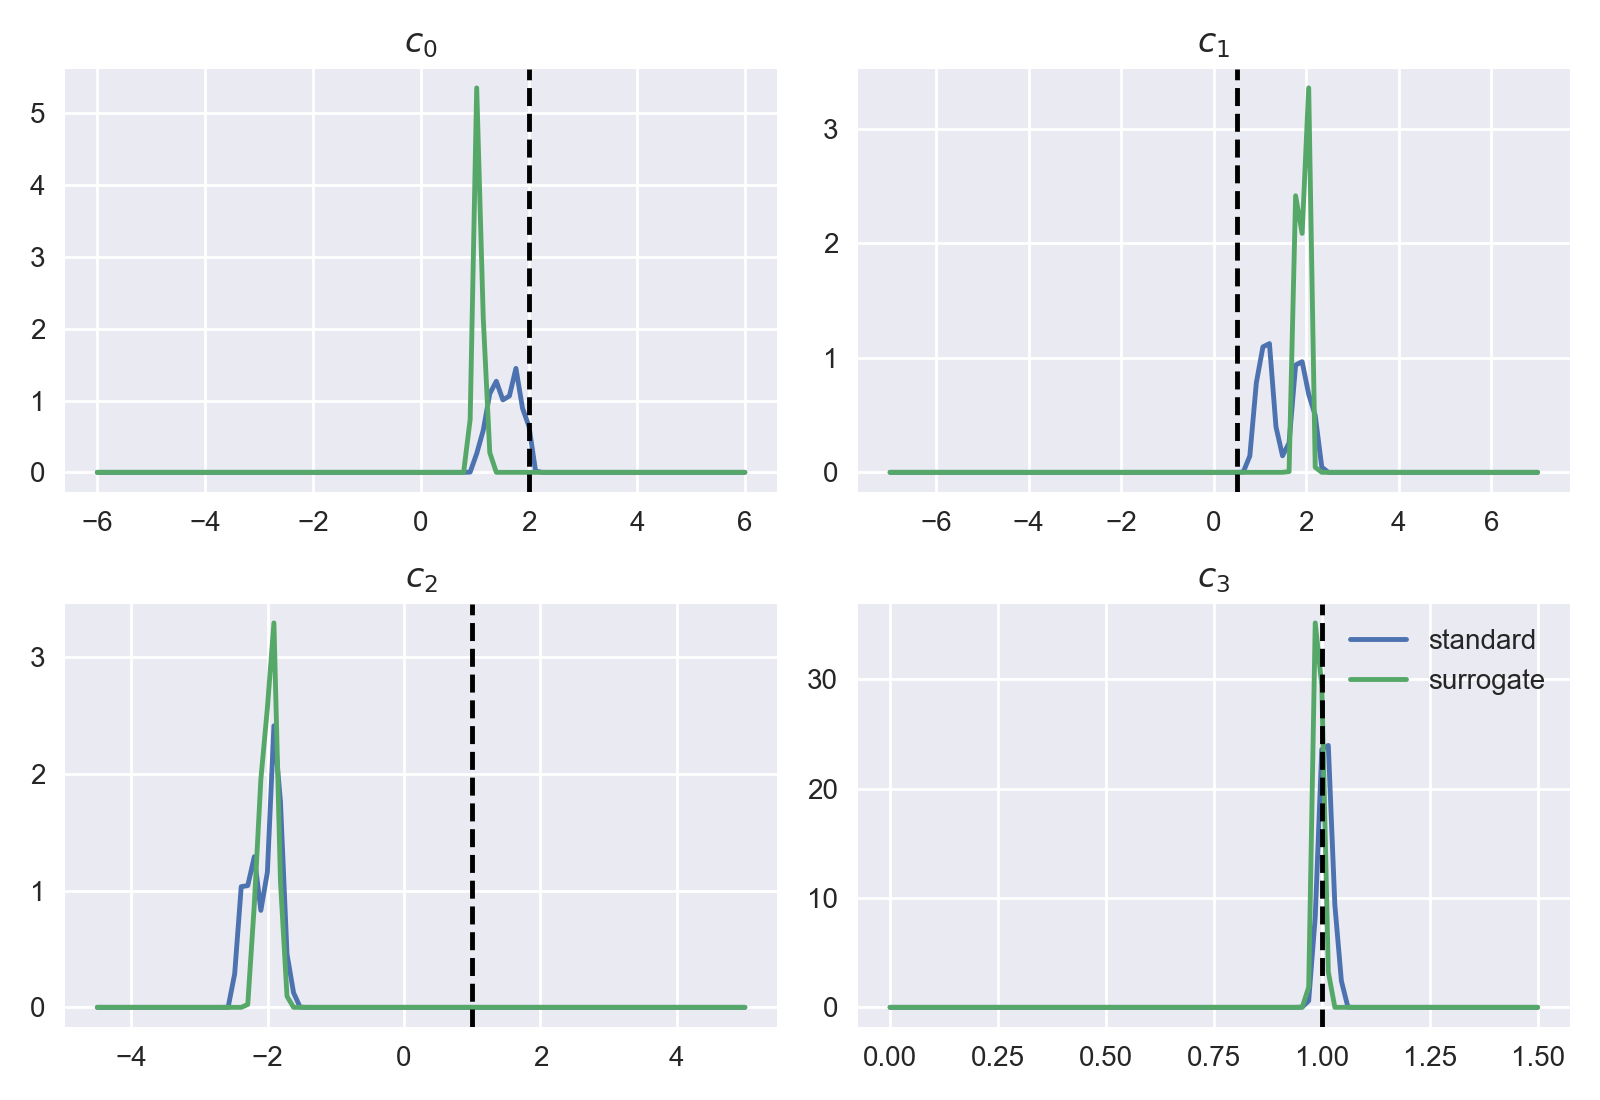

In [138]:
fig = plt.figure()
plt.subplot(221)
x = np.linspace(-6,6,100)
plt.plot(x,kdes_heat_std[0].pdf(x),label='standard')
plt.plot(x,kdes_heat_sur[0].pdf(x),label='surrogate')
plt.axvline(2,ls='--',c='k')
plt.title("$c_0$")

plt.subplot(222)
x = np.linspace(-7,7,100)
plt.plot(x,kdes_heat_std[1].pdf(x),label='standard')
plt.plot(x,kdes_heat_sur[1].pdf(x),label='surrogate')
plt.axvline(.5,ls='--',c='k')
plt.title("$c_1$")


plt.subplot(223)
x = np.linspace(-4.5,5,100)
plt.plot(x,kdes_heat_std[2].pdf(x),label='standard')
plt.plot(x,kdes_heat_sur[2].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$c_2$")

#
plt.subplot(224)
x = np.linspace(0,1.5,100)
plt.plot(x,kdes_heat_std[3].pdf(x),label='standard')
plt.plot(x,kdes_heat_sur[3].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$c_3$")


plt.tight_layout()
plt.legend()
plt.show()

In [139]:
u0 = c[0]*x_sur**3+c[1]*x_sur**2+c[2]*x_sur+c[3]
U_true = solve_1dheat(t_sur,x_sur,u0,u0[0],u0[-1],.1)

In [106]:
j = 52
t = t_sur[j]*np.ones_like(x_sur)

U_sur2,cov1 = heat_gp.predict(np.array((t,x_sur)).T,ret_cov=True)

In [102]:
t_obs.shape

(20,)

In [105]:
t_obs[10],t_sur[52]

(0.5263157894736842, 0.5252525252525253)

<IPython.core.display.Javascript object>


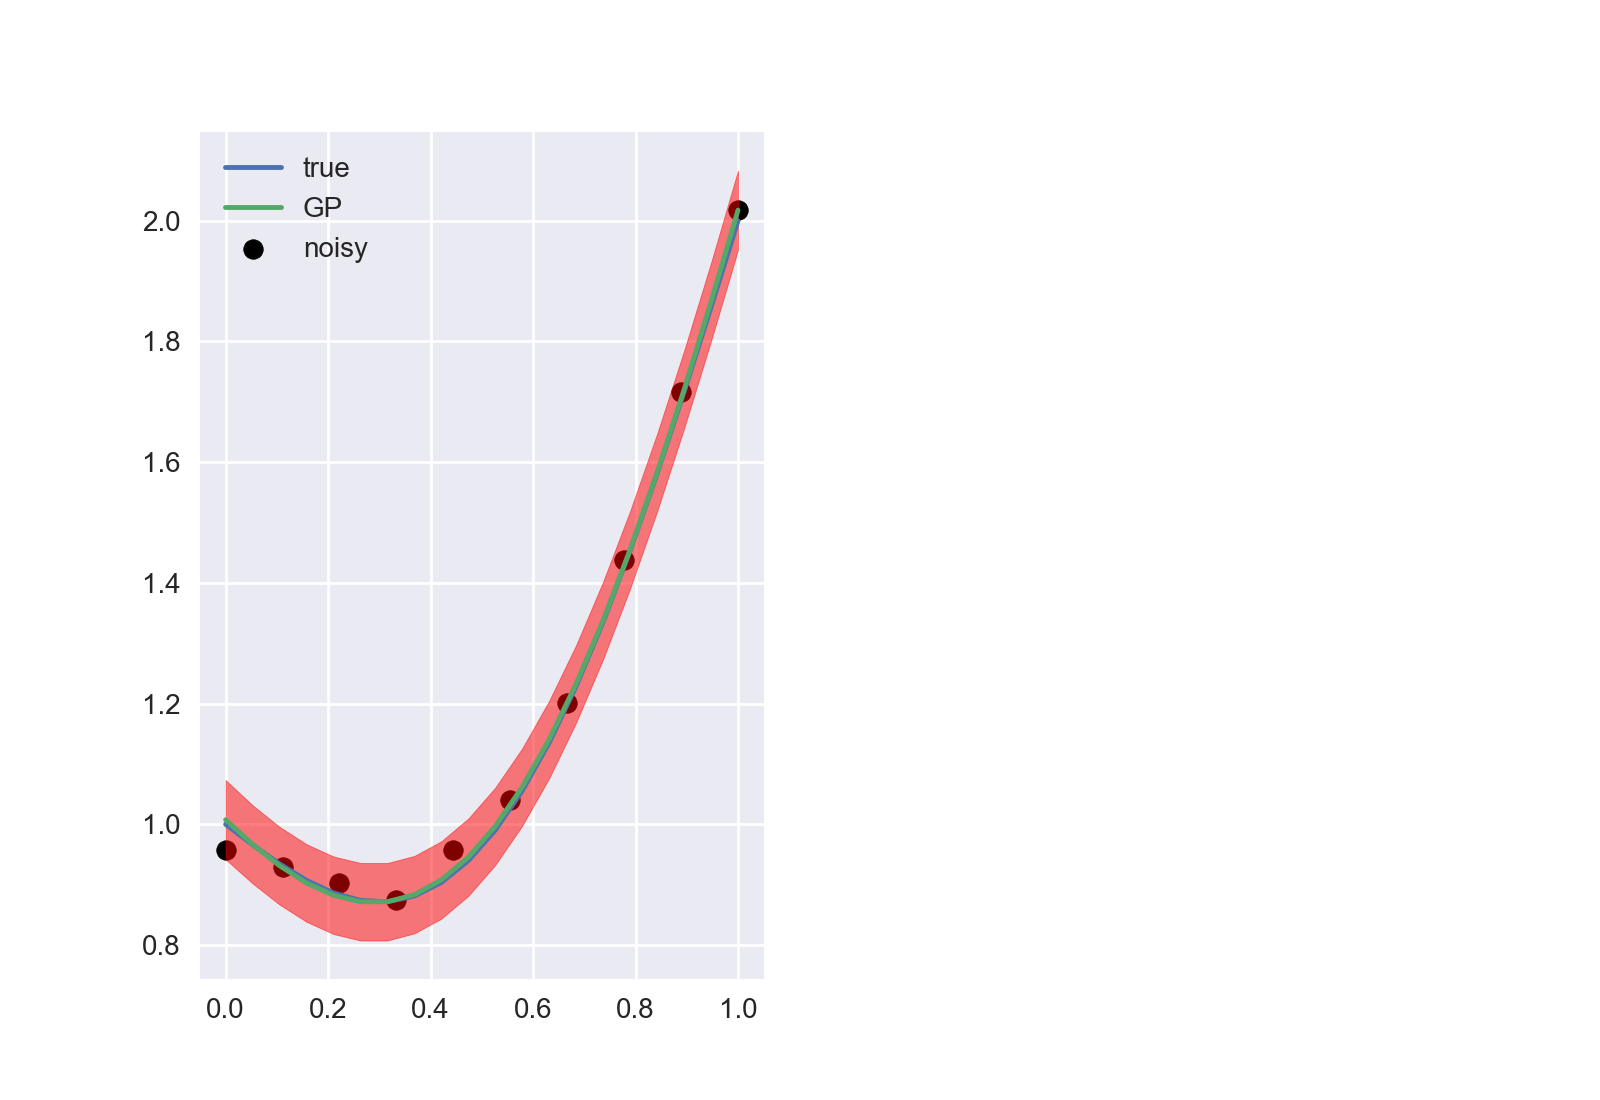

In [107]:
fig = plt.figure()
plt.subplot(121)
plt.plot(x_sur,U_true[j],label='true')
plt.scatter(x_obs,U_noisy[10],c='k',label='noisy')
plt.plot(x_sur,U_sur2,label='GP')
plt.fill_between(x_sur,U_sur2-2*np.sqrt(np.diag(cov1)),U_sur2+2*np.sqrt(np.diag(cov1)),color='r',alpha=.5)
# plt.subplot(122)
# plt.plot(T_sur,y_hr[1],label='true')
# plt.scatter(T,y_noisy[1],c='k',label='noisy')
# plt.plot(T_sur,mean2,label='GP')
# plt.fill_between(T_sur,mean2-2*np.sqrt(np.diag(cov2)),mean2+2*np.sqrt(np.diag(cov2)),color='r',alpha=.5)
plt.legend()
plt.show()

In [215]:
gp.kernels.ConstantKernel?